# Week 2 - Sampling & Reliability

Up until this week, we have assumed that the corpus you have used for analysis assignments represented a *meaningful* assemblage of texts from which reasonable inferences could be drawn about the social game, social world and social actors that produced it. 

This week, we ask you to build a corpus for preliminary analysis and articulate what your sample represents in context of your final project. We begin by exploring how we can get *human* readings of content at scale. We want to gather and utilize human responses for several reasons. First, we may want to use crowdsourced human scores as the primary method of coding, extracting or organizing content (as it was in two of the assigned readings). Second, we may want to validate or tune a computational algorithm we may have developed in terms of how it is associated with human meanings or experience. Finally, we may want to use human coding on a sample of data as the basis for training a model or algorithm to then extrapolate *human-like* annotations to the entire population. Here intelligent sampling is critical to maximize effective maching training. 

For this notebook we will be using the following packages

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
import numpy as np #For arrays
import scipy as sp #For some stats
import pandas #Gives us DataFrames
import pandas as pd
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import pyanno #On python3 make sure to pip install pyanno3

#We need to import these this way due to how pyanno is setup
from pyanno.measures import pairwise_matrix, agreement, cohens_kappa, cohens_weighted_kappa, fleiss_kappa, krippendorffs_alpha, pearsons_rho, scotts_pi, spearmans_rho
from pyanno.annotations import AnnotationsContainer
from pyanno.models import ModelA, ModelBt, ModelB

from functools import reduce
from itertools import permutations
import math


#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

import warnings
warnings.filterwarnings("ignore")

## <span style="color:red">*Pitch the Domain of your Project*</span>

<span style="color:red">In the two cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words) and **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words)? [**Note**: your individual or collective project can change over the course of the quarter if new data and/or analysis opportunities arise or if old ones fade away.]

## ***What?*** 
<200 words

By performing content analysis on political speeches from all U.S. presidents, from the First Inaugural Address by George Washington to the latest White House press conference on the coronavirus delivered by Donald Trump, my project aims to **reveal official U.S. perception towards China**. I wish to interrogate how the relations between the U.S. and China evolve over time. Specifically, research questions such as how the main topics on the agenda have changed and how positive and/or negative attitudes have altered will be taken into consideration.  Furthermore, I hope to discover whether there is a major difference within stances towards China between the Democrats and the Republicans by examining their presidential speeches.

As mentioned in previous assignment, the U.S. presidential speech corpora were constructed by dynamical web crawling [Miller Center](https://millercenter.org/the-presidency/presidential-speeches).

## ***Why?***
<200 words

The dynamics of U.S. presidential preception towards China not only helps to reveal the political relations between the superpower, the U.S., and one of the world powers, China, but also facilitates people to comprehend the U.S. diplomatic policies over the years. 

 

Theoretically, few existing political science studies employed quantitative methods to investigate the dynamics of U.S.-China Relations. In addition to that, papers are more focused on a media-centered perspective ([Chen, Xi, and Francisco X. Garcia., 2016](https://search.proquest.com/docview/1833248134?pq-origsite=gscholar)), which might not accurately shed light on the changes in the U.S. official tones. Therefore, I hope the project can make up with the gap between quantitative and qualitative analysis, and bridge the studies between official and unofficial U.S. descriptions of China.



Practically, the U.S.-China relation plays an indispensable role in the general public's everyday life. For example, due to Trump's tough anti-globalization attitude, the high-tariff on Chinese goods policies have halted the process of trade liberalization and have left a negative influence on Chinese international trade practitioners. Therefore, a deeper understanding of the U.S.-China relations is beneficial to guide the assessment of political risks on life.

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication)? (<200 words).

The social work is the presidential speeches addresses by all the U.S. presidents from George Washington to Donald Trump and the social actors are the U.S. presidents as mentioned above. Since the project intends to investigate the U.S.-China relations, not all discourses are of research interest. I try to sample China-related speeches by searching the relevant keywords such as "China", "Chinese" and etc. A rough count shows that there are at least 213 pieces of speeches that can be used for analysis, thus I have sufficient data to perform the study.  With the first China-related speech delivered by John Adams on December 6, 1825, and the latest one spoken by Donald Trump on March 13, 2020, the chosen samples cross a wide time span which is conducive to time-series analysis.


However, the president's attitudes towards China can be disclosed by studying their social media such as Tweets, which results in the limitation of the project, especially given that the remarks on social platforms might process much broader and far-reaching effects nowadays. For robustness, it is reasonable to "scale up" the sample by analyzing the president's tweets for future analysis.

# Example Annotation Dataset

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data). This data is the result of a content analytic / content extraction study in which Andrey Rzhetsky and colleagues from the National Library of Medicine, published [here](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000391) in [PLOS Computational Biology](http://journals.plos.org/ploscompbiol/), gave eight annotators 10,000 sentence chunks from biomedical text in biomedical abstracts and articles, then asked them, in a loop design schematically illustrated below that provided 3 independent codings for each document. The sampling strategy pursued diversity by drawing from PubMed abstracts (1000) and full-text articles (9000: 20% from abstracts, 10% from introductions, 20% from methods, 25% from results, and 25% from discussions.) The dataset extract here involves respondents codes for sentences in terms of their *Evidence*: {0, 1, 2, 3, -1} where 0 is the complete lack of evidence, 3 is direct evidence present within the sentence, and -1 is didn't respond. (They also crowdsourced and analyzed *polarity*, *certainty*, and *number*). For example, consider the following two abutting sentence chunks: *"Because null mutations in toxR and toxT abolish CT and TcpA expression in the El Tor biotype and also attenuate virulence..."* [i.e., average certainty = 0], *"...it is likely that the ToxR regulon has functional similarities between the two biotypes despite the clear differences in the inducing parameters observed in vitro"* [i.e., average certainty = 1]."

In [2]:
%%html
<img source="loopdesign.png">

[Click here for loop design](loopdesign.png)

In [3]:
x = np.loadtxt("../data/pyAnno/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

In [4]:
anno

Interrogate the AnnotationsContainer object.

In [5]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [6]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [7]:
anno.missing_values

[-1]

# Annotation Statistics

First, we assume categorical codes...that each code is qualitatively distinct from each other. Two measures are primarily used for this: **Scott's $\pi$**, **Cohen's $\kappa$**, and **Krippendorff's $\alpha$**
which **each measure the extent of agreement between two annotators**, but take into account **the possibility of the agreement occurring by chance in slightly different ways**. Any agreement measure begins with the frequency of codes:

In [8]:
pyanno.measures.agreement.labels_frequency(anno.annotations,4)

array([0.11666667, 0.245     , 0.34083333, 0.2975    ])

Now consider **the "confusion matrix"** or **matrix of coded agreements** between any two coders:

[[ 8.  7.  3.  2.]
 [ 9. 30. 13.  3.]
 [ 2.  9. 42. 11.]
 [ 1.  7. 14. 39.]]


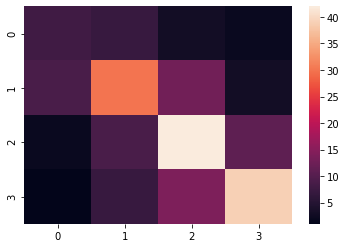

In [9]:
c = pyanno.measures.agreement.confusion_matrix(anno.annotations[:,0], anno.annotations[:,1],4)
print(c)
ac = seaborn.heatmap(c)
plt.show()

[**Scott's $\pi$**](https://en.wikipedia.org/wiki/Scott's_Pi) is computed as:

$\pi = \frac{\text{Pr}(a)-\text{Pr}(e)}{1-\text{Pr}(e)}$

Where **Pr($a$) is relative observed agreement**, and **Pr($e$) is expected agreement** using joint proportions calculated from the confusion matrix or matrix of coded agreements between any two coders:

In [10]:
scotts_pi(anno.annotations[:,0], anno.annotations[:,1])

0.4386478265891502

The **generalization** of Scott's $\pi$ to $n$ coders is [**Fleiss' $\kappa$**](https://en.wikipedia.org/wiki/Fleiss%27_kappa) (Fleiss called it $\kappa$ because he thought he was generalizing Cohen's $\kappa$)

In [11]:
fleiss_kappa(anno.annotations[::])

0.40417653771912765

[**Krippendorff's $\alpha$**](https://en.wikipedia.org/wiki/Krippendorff%27s_alpha) generalizes of Fleiss' $\kappa$ to $n$ coders and takes into account the fact that annotations here are not categorically different, but ordinal, by adding **a weight matrix** in which **off-diagonal cells contain weights indicating the seriousness of the disagreement between each score**. When produced with no arguments, it simply produces **an arithmetic distance** (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc.

In [12]:
krippendorffs_alpha(anno.annotations[::])

0.6472588223831547

Like Scott's $\pi$, [**Cohen's $\kappa$**](https://en.wikipedia.org/wiki/Cohen%27s_kappa) also takes into account the possibility of the agreement occurring by chance, but in the following way:

$\kappa = \frac{p_o-p_e}{1-p_e}=1-\frac{1-p_o}{p_e}$

where $p_o$ is **the relative observed agreement among raters**, and $p_e$ is **the hypothetical probability of chance agreement**, using the observed data to calculate the probabilities of each observer randomly saying each category. If the raters are in complete agreement then $\kappa = 1$. **If there is no agreement among the raters other than what would be expected by chance (as given by $p_e$), $\kappa ≤ 0 $.** Here, Cohen's $\kappa$ statistic for the first two annotators is computed. This is probably the most common metric of agreement.

In [13]:
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

[[1.         0.43917037 0.47677621        nan        nan        nan
  0.45819119 0.43381462]
 [0.43917037 1.         0.38432922 0.41344423        nan        nan
         nan 0.33643611]
 [0.47677621 0.38432922 1.         0.39583333 0.51704894        nan
         nan        nan]
 [       nan 0.41344423 0.39583333 1.         0.34597068 0.4446844
         nan        nan]
 [       nan        nan 0.51704894 0.34597068 1.         0.37938644
  0.43039733        nan]
 [       nan        nan        nan 0.4446844  0.37938644 1.
  0.38341929 0.31214748]
 [0.45819119        nan        nan        nan 0.43039733 0.38341929
  1.         0.394806  ]
 [0.43381462 0.33643611        nan        nan        nan 0.31214748
  0.394806   1.        ]]


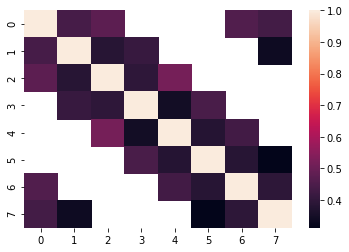

In [14]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print(m)
ax = seaborn.heatmap(m)
plt.show()

You can see that this **8 by 3 loop design** will be less stable than an 8 choose 3 combinatorial design, because each codes with more others. 

One can also assess the average Cohen's $\kappa$ for all pairs of coders that have coded against one another:

In [15]:
help(permutations)

Help on class permutations in module itertools:

class permutations(builtins.object)
 |  permutations(iterable[, r]) --> permutations object
 |  
 |  Return successive r-length permutations of elements in the iterable.
 |  
 |  permutations(range(3), 2) --> (0,1), (0,2), (1,0), (1,2), (2,0), (2,1)
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  __setstate__(...)
 |      Set state information for unpickling.
 |  
 |  __sizeof__(...)
 |      Returns size in memory, in bytes.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



In [16]:
anno.annotations[0, :]

array([ 1,  2,  3, -1, -1, -1, -1, -1])

In [17]:
permutations(range(8),2)

In [18]:
for p in permutations(range(8), 2):
    print(p)

(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(1, 0)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(2, 0)
(2, 1)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(3, 0)
(3, 1)
(3, 2)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 5)
(4, 6)
(4, 7)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 6)
(5, 7)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 7)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)


In [19]:
cohens_kappa(anno.annotations[:, 0], anno.annotations[:, 1])

0.43917037219392857

In [20]:
cohens_kappa(anno.annotations[:, 0], anno.annotations[:, 2])

0.4767762070864697

In [21]:
m = [cohens_kappa(anno.annotations[:, 0], anno.annotations[:, 1]), 
    cohens_kappa(anno.annotations[:, 0], anno.annotations[:, 2])]
clean_m = [c for c in m if not math.isnan(c)]
clean_m

[0.43917037219392857, 0.4767762070864697]

In [22]:
reduce(lambda a, b: a + b, clean_m) / len(clean_m)

0.4579732896401991

In [23]:
def pairwise_metric_average(metric, array):
    """Calculate the pairwise metric average for the real elements of metric function run on an array of annotations"""
    p = permutations(range(array[0,:].size),2)
    m = [metric(array[:,x[0]], array[:,x[1]]) for x in p]
    clean_m = [c for c in m if not math.isnan(c)]
    return reduce(lambda a, b: a + b, clean_m)/len(clean_m)    
 
pairwise_metric_average(cohens_kappa, anno.annotations)

0.40911598940065674

As recognized with Krippendorff's flexible $\alpha$, our scores are *not* categorical, but rather ordered and **her considered(what's this???)** metric. Weighted $\kappa$ allows you to count disagreements differently and is useful when codes are ordered as they are here. Here a weight matrix is added to the calculation, in which off-diagonal cells contain weights indicating the seriousness of the disagreement between each score. When automatically produced, it simply produces an arithmetic distance (e.g., 3-1=2), such that cells one off the diagonal are weighted 1, two off 2, etc. Here

$\kappa = 1-\frac{\sum^k_{i=1}\sum^k_{j=1}w_{ij}x_{ij}}{\sum^k_{i=1}\sum^k_{j=1}w_{ij}m_{ij}}$

where $\kappa$ = $n$ codes and $w_{ij}$,$x_{ij}$, and $m_{ij}$ represent elements in the weight, observed, and expected matrices, respectively. (Obviously, when diagonal cells contain weights of 0 and off-diagonal cells weights of 1, this equals $\kappa$).

In [24]:
cohens_weighted_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.5330240507874497

Or averaged over the total:

In [25]:
pairwise_metric_average(cohens_weighted_kappa,anno.annotations)

0.5299113458717166

Alternatively, if the annontation data can be understood as indicating real values, we can assess not agreement, but rather **the correlation of values (Pearson's $\rho$)** or **correlation of ranks (Spearman's $\rho$)** for pairs of coders:

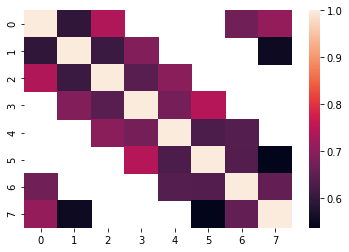

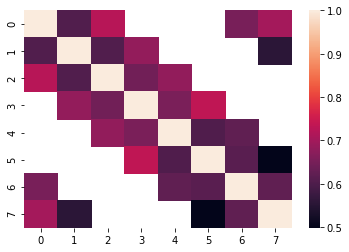

In [26]:
n = pairwise_matrix(pearsons_rho, anno.annotations)
m = pairwise_matrix(spearmans_rho, anno.annotations)
an = seaborn.heatmap(n)
plt.show()
am = seaborn.heatmap(m)
plt.show()

Or averaged over all comparable pairs:

In [27]:
print(pairwise_metric_average(pearsons_rho,anno.annotations), 
      pairwise_metric_average(spearmans_rho,anno.annotations))

0.6517219321175077 0.63808488688039


## <span style="color:red">*Your turn*</span>

<span style="color:red">Perform a content annotation survey of some kind in which at least 3 people evaluate and code each piece of content, using Amazon Mechanical Turk as described in the MTurk slides in the Assignment link on Canvas, or by hand with friends.  With the resulting data, calculate, visualize and discuss inter-coder agreement or covariation with appropriate metrics. What does this means for the reliability of human assessments regarding content in your domain?

The annotation survey is conducted in the following way. I randomly pick five China-related sentences from Trump's speeches and five China-related sentences from Obama's speeches to construct a presidential speech sample of 10 sentences. Then I invited eight of my friends to rate the sentence by their attitudes towards China. To ensure the accuracy of the survey not being affected by the individuals per se, presidents' names will not be shown along with the chosen sentences. The attitudes range from "Strongly Negative", "Negative", "Neutral", "Positive", "Strongly Positive" and "Unsure", with scores of 1, 2, 3, 4, 5, and -1 respectively.

The rating table in the survey is shown as follows:

| Index | Score | Sentences                                                    | President(Not Shown in Real Survey) |
| ----- | :---: | :----------------------------------------------------------- | ----------------------------------- |
| 0     |       | Meanwhile,  China's not waiting to revamp its economy.       | Barack Obama                        |
| 1     |       | We’re  working—our drug companies, our pharmaceutical companies are working very  closely with China and with India, as you know, and with, all over the world. | Donald Trump                        |
| 2     |       | I also  promised our citizens that I would impose tariffs to confront China’s massive  theft of America’s jobs. | Donald Trump                        |
| 3     |       | But right  now, it’s getting more expensive to do business in places like China. | Barack Obama                        |
| 4     |       | We’ve  reasserted our power across the Pacific and stood up to China on behalf of  our workers. | Barack Obama                        |
| 5     |       | But  I don’t blame China for taking advantage of us—I blame our leaders  and representatives for allowing this travesty to happen. | Donald Trump                        |
| 6     |       | The  American people are absolutely committed to restoring balance to our  relationship with China. | Donald Trump                        |
| 7     |       | Recently,  we signed agreements with India and China that will support more than 250,000  jobs here in the United States. | Barack Obama                        |
| 8     |       | And now  we’re going to sit back and watch China build newer airports and faster  railroads? | Barack Obama                        |
| 9     |       | But we’re  very much working very closely with China and President Xi, who I respect a  lot. | Donald Trump                        |



Note that the loop design is not implemented because of its instability. The responses can be found in `response.txt`.

In [28]:
# Load the annotation response data
response = np.loadtxt("response.txt")
response

array([[3., 3., 3., 3., 3., 4., 4., 2.],
       [4., 4., 4., 3., 3., 4., 5., 4.],
       [1., 1., 1., 1., 2., 1., 1., 1.],
       [2., 2., 3., 2., 3., 4., 2., 2.],
       [1., 2., 1., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 3., 1., 3., 3.],
       [3., 3., 5., 2., 3., 2., 4., 3.],
       [3., 4., 4., 3., 3., 2., 3., 4.],
       [2., 2., 1., 2., 2., 1., 2., 2.],
       [5., 4., 5., 4., 4., 3., 4., 4.]])

In [29]:
# Extract Trump's and Obama's speeches respectively
trump = response[[1, 2, 5, 6, 9], :]
obama = response[[0, 3, 4, 7, 8], :]
print("Trump:\n", trump)
print("Obama:\n", obama)

Trump:
 [[4. 4. 4. 3. 3. 4. 5. 4.]
 [1. 1. 1. 1. 2. 1. 1. 1.]
 [2. 2. 2. 2. 3. 1. 3. 3.]
 [3. 3. 5. 2. 3. 2. 4. 3.]
 [5. 4. 5. 4. 4. 3. 4. 4.]]
Obama:
 [[3. 3. 3. 3. 3. 4. 4. 2.]
 [2. 2. 3. 2. 3. 4. 2. 2.]
 [1. 2. 1. 2. 2. 2. 2. 2.]
 [3. 4. 4. 3. 3. 2. 3. 4.]
 [2. 2. 1. 2. 2. 1. 2. 2.]]


In [30]:
# Set the missing values to -1
response_anno = AnnotationsContainer.from_array(response, missing_values=[-1])
trump_anno = AnnotationsContainer.from_array(trump, missing_values=[-1])
obama_anno = AnnotationsContainer.from_array(obama, missing_values=[-1])

In [31]:
# Check the labels
response_anno.labels

[1.0, 2.0, 3.0, 4.0, 5.0]

In [32]:
# Check the label for the missing values
response_anno.missing_values

[]

Everyone in the survey has given unambiguous answers to the evalutions of attitudes towards China in both presidents' speeches, so there is no missing values.

In [33]:
# Calculate the frequency of each type of response in the total response, in response regarding Trump's and Obama's speeches respective;y
print("Frequencey in All Speeches Responses: ", pyanno.measures.agreement.labels_frequency(response_anno.annotations, 5))
print("Frequencey in Trump's Speeches Responses: ", pyanno.measures.agreement.labels_frequency(trump_anno.annotations, 5))
print("Frequencey in Obama's Speeches Responses: ", pyanno.measures.agreement.labels_frequency(obama_anno.annotations, 5))

Frequencey in All Speeches Responses:  [0.15   0.325  0.2625 0.2125 0.05  ]
Frequencey in Trump's Speeches Responses:  [0.2   0.175 0.25  0.275 0.1  ]
Frequencey in Obama's Speeches Responses:  [0.1   0.475 0.275 0.15  0.   ]


Basically, attitudes towards China in Trump's speeches are more polarized than that in Obama's speeches according to the frequency of each type of responses. However, this if not a concrete conclusion due to the limited number of samples.

### Annotation Statistics

**Confusion Matrix**

In [34]:
# Define a function that calculate and plot the confusion matrix between any two coders
def confusion_matrix(coder1, coder2, num_labels):
    c = pyanno.measures.agreement.confusion_matrix(coder1, coder2, num_labels)
    print(c)
    ac = seaborn.heatmap(c)
    plt.show();

The confusion matrix between coder 1 and coder 2.
[[1. 1. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 0. 2. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


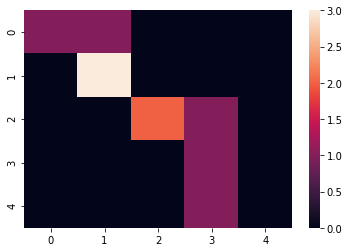



The confusion matrix between coder 1 and coder 3.
[[2. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


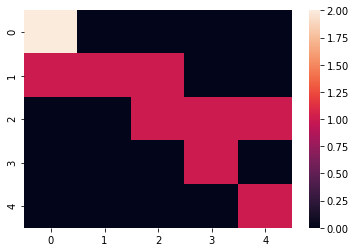



The confusion matrix between coder 1 and coder 4.
[[1. 1. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


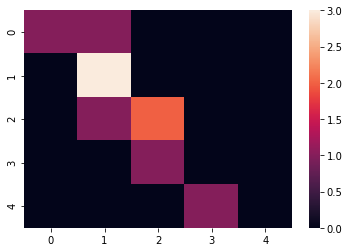



The confusion matrix between coder 1 and coder 5.
[[0. 2. 0. 0. 0.]
 [0. 1. 2. 0. 0.]
 [0. 0. 3. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


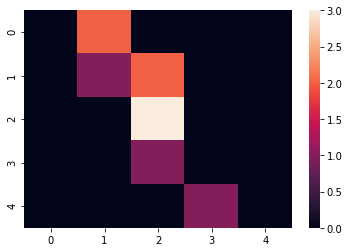



The confusion matrix between coder 1 and coder 6.
[[1. 1. 0. 0. 0.]
 [2. 0. 0. 1. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


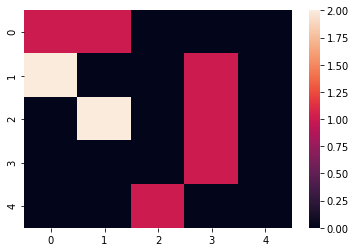



The confusion matrix between coder 1 and coder 7.
[[1. 1. 0. 0. 0.]
 [0. 2. 1. 0. 0.]
 [0. 0. 1. 2. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


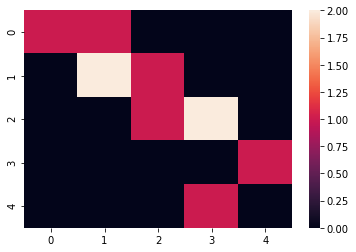



The confusion matrix between coder 1 and coder 8.
[[1. 1. 0. 0. 0.]
 [0. 2. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


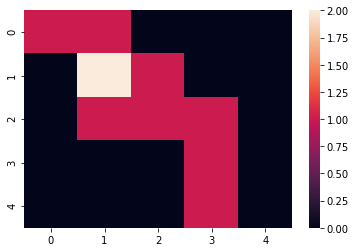



The confusion matrix between coder 2 and coder 3.
[[1. 0. 0. 0. 0.]
 [2. 1. 1. 0. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 2. 1.]
 [0. 0. 0. 0. 0.]]


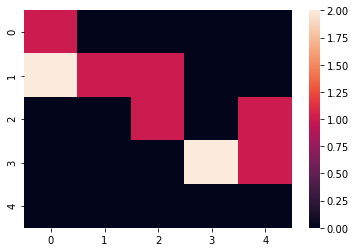



The confusion matrix between coder 2 and coder 4.
[[1. 0. 0. 0. 0.]
 [0. 4. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 2. 1. 0.]
 [0. 0. 0. 0. 0.]]


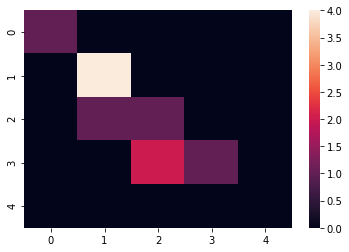



The confusion matrix between coder 2 and coder 5.
[[0. 1. 0. 0. 0.]
 [0. 2. 2. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 2. 1. 0.]
 [0. 0. 0. 0. 0.]]


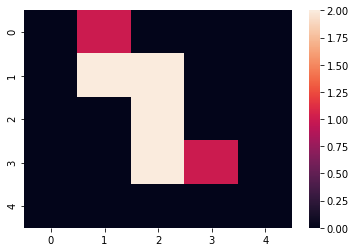



The confusion matrix between coder 2 and coder 6.
[[1. 0. 0. 0. 0.]
 [2. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]


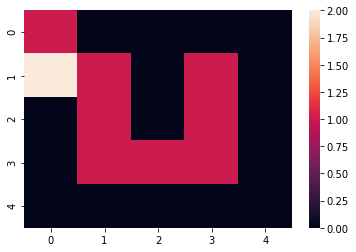



The confusion matrix between coder 2 and coder 7.
[[1. 0. 0. 0. 0.]
 [0. 3. 1. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0.]]


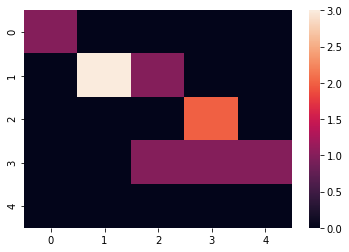



The confusion matrix between coder 2 and coder 8.
[[1. 0. 0. 0. 0.]
 [0. 3. 1. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0.]]


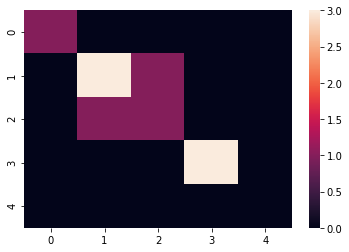



The confusion matrix between coder 3 and coder 4.
[[1. 2. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 1. 0. 1. 0.]]


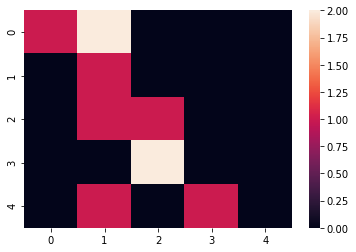



The confusion matrix between coder 3 and coder 5.
[[0. 3. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 1. 1. 0.]]


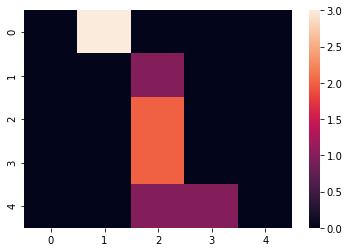



The confusion matrix between coder 3 and coder 6.
[[2. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0.]]


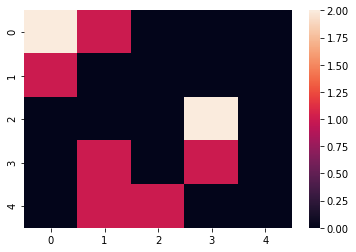



The confusion matrix between coder 3 and coder 7.
[[1. 2. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 2. 0.]]


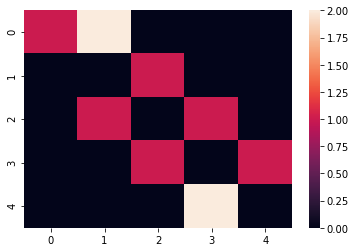



The confusion matrix between coder 3 and coder 8.
[[1. 2. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 1. 1. 0.]]


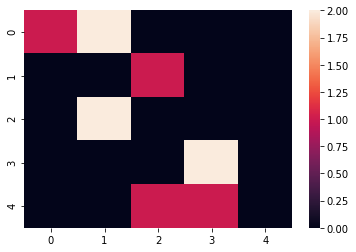



The confusion matrix between coder 4 and coder 5.
[[0. 1. 0. 0. 0.]
 [0. 2. 3. 0. 0.]
 [0. 0. 3. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


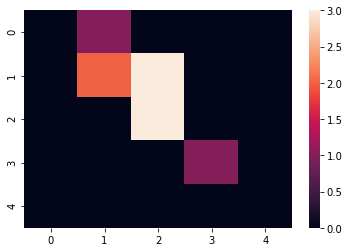



The confusion matrix between coder 4 and coder 6.
[[1. 0. 0. 0. 0.]
 [2. 2. 0. 1. 0.]
 [0. 1. 0. 2. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


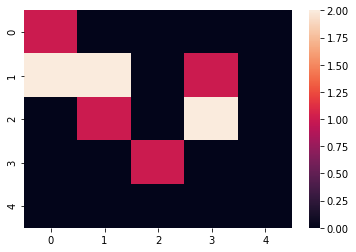



The confusion matrix between coder 4 and coder 7.
[[1. 0. 0. 0. 0.]
 [0. 3. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


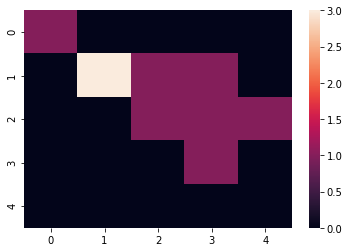



The confusion matrix between coder 4 and coder 8.
[[1. 0. 0. 0. 0.]
 [0. 3. 2. 0. 0.]
 [0. 1. 0. 2. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


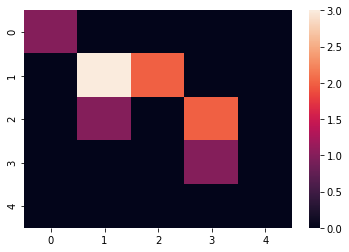



The confusion matrix between coder 5 and coder 6.
[[0. 0. 0. 0. 0.]
 [2. 1. 0. 0. 0.]
 [1. 2. 0. 3. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


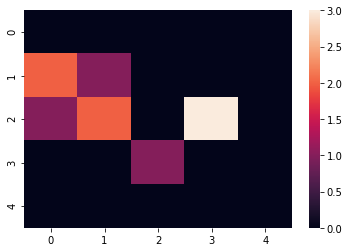



The confusion matrix between coder 5 and coder 7.
[[0. 0. 0. 0. 0.]
 [1. 2. 0. 0. 0.]
 [0. 1. 2. 2. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


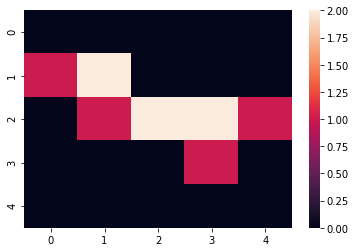



The confusion matrix between coder 5 and coder 8.
[[0. 0. 0. 0. 0.]
 [1. 2. 0. 0. 0.]
 [0. 2. 2. 2. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


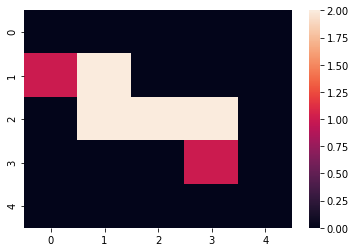



The confusion matrix between coder 6 and coder 7.
[[1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0.]]


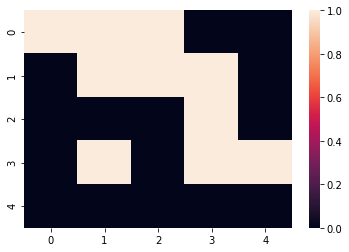



The confusion matrix between coder 6 and coder 8.
[[1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


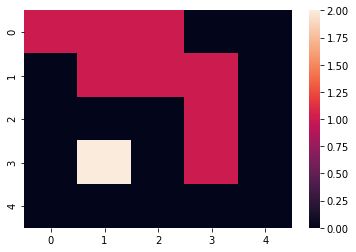



The confusion matrix between coder 7 and coder 8.
[[1. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 0.]]


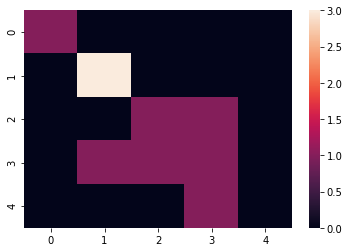

In [35]:
# Calculate and plot the confusion matrix between the testees in the annotation survey
# All speeches responses
for i in range(8):
    for j in range(i + 1, 8):
        print("The confusion matrix between coder {} and coder {}.".format(i+1, j+1))
        coder1 = response_anno.annotations[:, i]
        coder2 = response_anno.annotations[:, j]
        confusion_matrix(coder1, coder2, 5)
        print("\n")

The confusion matrix between coder 1 and coder 2.
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


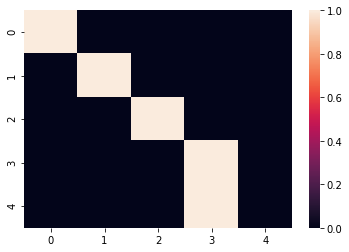



The confusion matrix between coder 1 and coder 3.
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


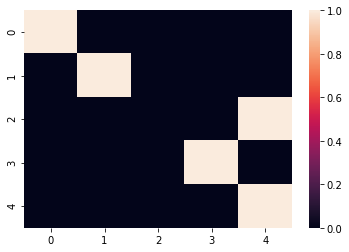



The confusion matrix between coder 1 and coder 4.
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


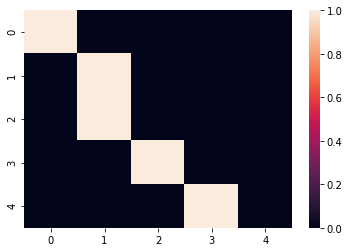



The confusion matrix between coder 1 and coder 5.
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


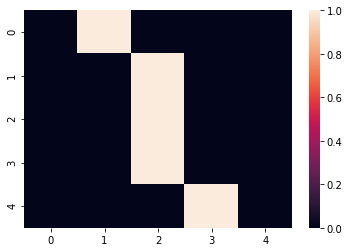



The confusion matrix between coder 1 and coder 6.
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]]


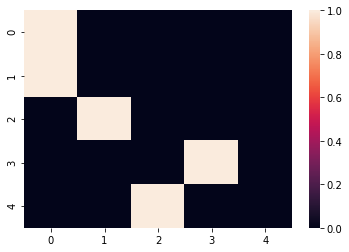



The confusion matrix between coder 1 and coder 7.
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


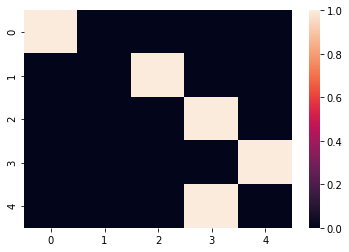



The confusion matrix between coder 1 and coder 8.
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


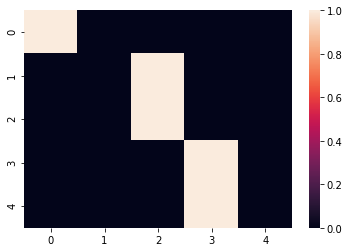



The confusion matrix between coder 2 and coder 3.
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0.]]


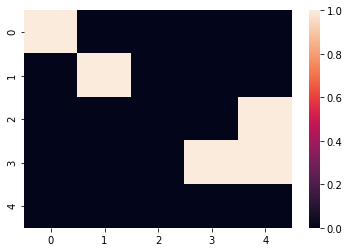



The confusion matrix between coder 2 and coder 4.
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]


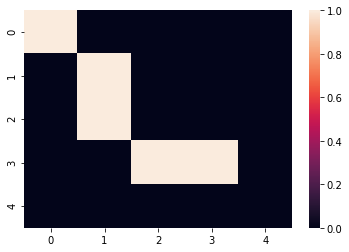



The confusion matrix between coder 2 and coder 5.
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]


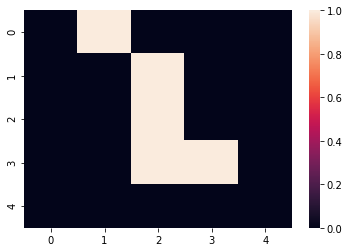



The confusion matrix between coder 2 and coder 6.
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]]


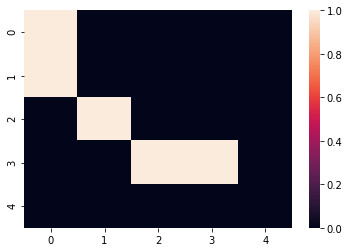



The confusion matrix between coder 2 and coder 7.
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0.]]


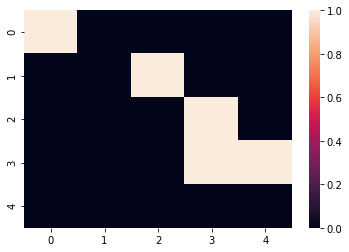



The confusion matrix between coder 2 and coder 8.
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 0. 0. 0. 0.]]


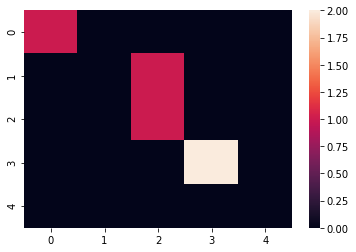



The confusion matrix between coder 3 and coder 4.
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]]


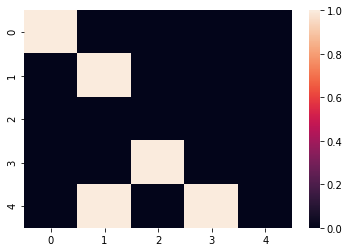



The confusion matrix between coder 3 and coder 5.
[[0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0.]]


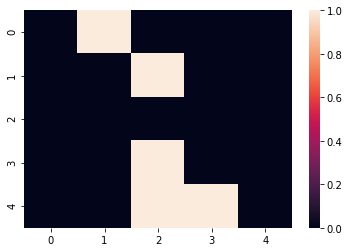



The confusion matrix between coder 3 and coder 6.
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0.]]


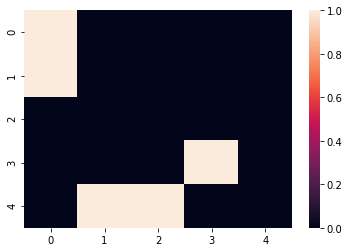



The confusion matrix between coder 3 and coder 7.
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 2. 0.]]


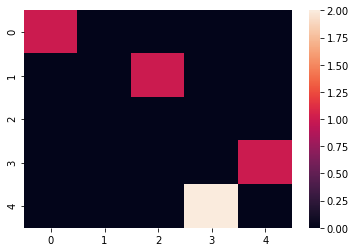



The confusion matrix between coder 3 and coder 8.
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0.]]


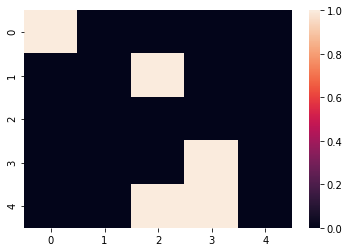



The confusion matrix between coder 4 and coder 5.
[[0. 1. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


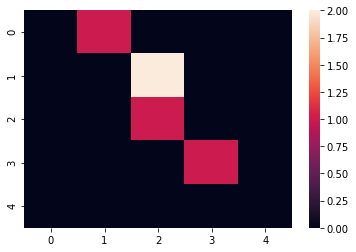



The confusion matrix between coder 4 and coder 6.
[[1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


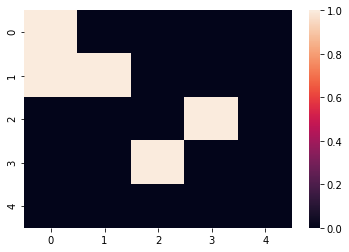



The confusion matrix between coder 4 and coder 7.
[[1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


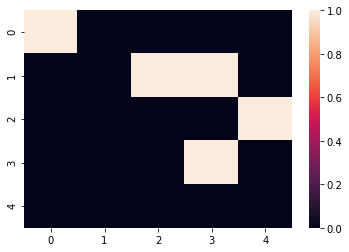



The confusion matrix between coder 4 and coder 8.
[[1. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


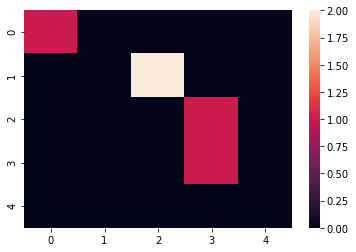



The confusion matrix between coder 5 and coder 6.
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


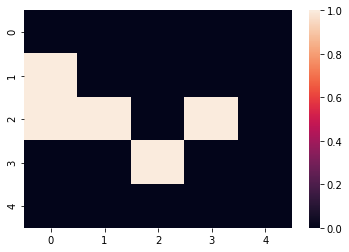



The confusion matrix between coder 5 and coder 7.
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


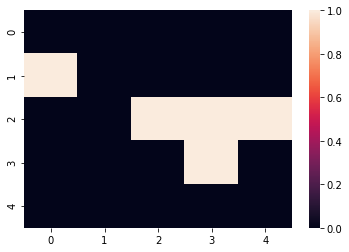



The confusion matrix between coder 5 and coder 8.
[[0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 2. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


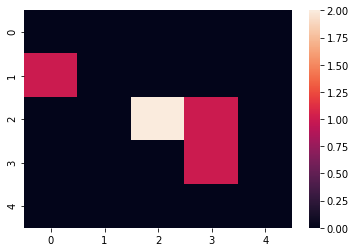



The confusion matrix between coder 6 and coder 7.
[[1. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]


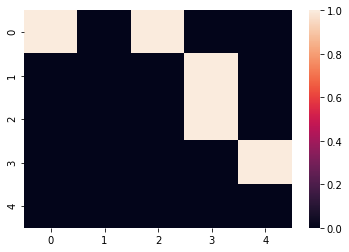



The confusion matrix between coder 6 and coder 8.
[[1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


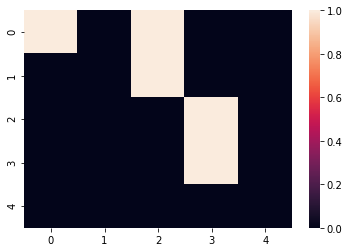



The confusion matrix between coder 7 and coder 8.
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 1. 0.]]


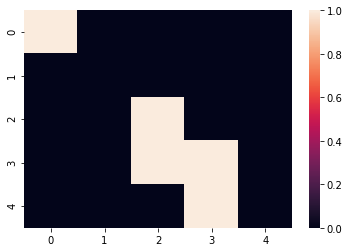

In [36]:
# Trump's speeches responses
for i in range(8):
    for j in range(i + 1, 8):
        print("The confusion matrix between coder {} and coder {}.".format(i+1, j+1))
        coder1 = trump_anno.annotations[:, i]
        coder2 = trump_anno.annotations[:, j]
        confusion_matrix(coder1, coder2, 5)
        print("\n")

The confusion matrix between coder 1 and coder 2.
[[0. 1. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


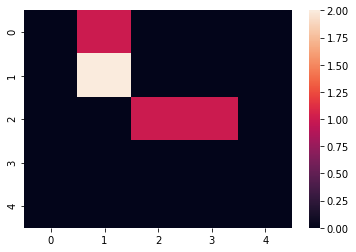



The confusion matrix between coder 1 and coder 3.
[[1. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


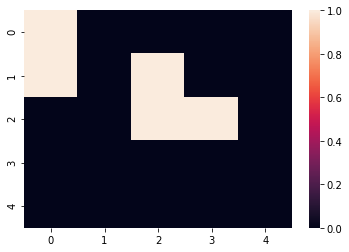



The confusion matrix between coder 1 and coder 4.
[[0. 1. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


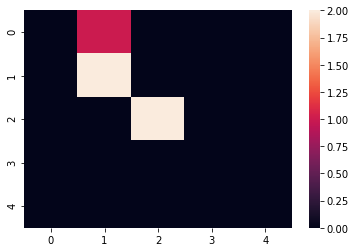



The confusion matrix between coder 1 and coder 5.
[[0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


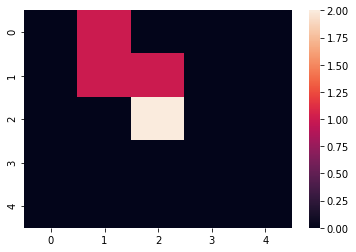



The confusion matrix between coder 1 and coder 6.
[[0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


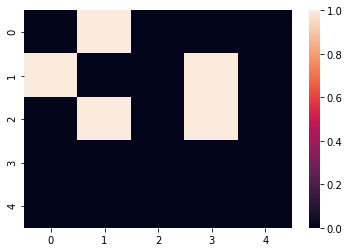



The confusion matrix between coder 1 and coder 7.
[[0. 1. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


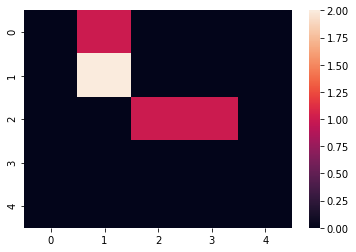



The confusion matrix between coder 1 and coder 8.
[[0. 1. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


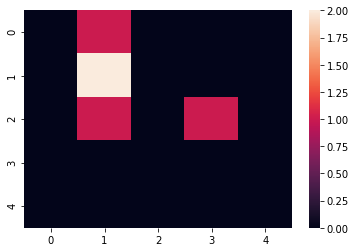



The confusion matrix between coder 2 and coder 3.
[[0. 0. 0. 0. 0.]
 [2. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


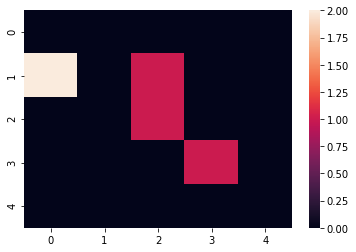



The confusion matrix between coder 2 and coder 4.
[[0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


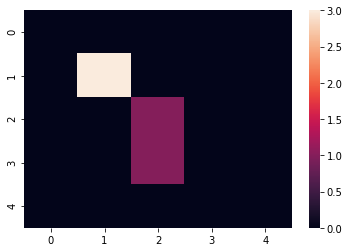



The confusion matrix between coder 2 and coder 5.
[[0. 0. 0. 0. 0.]
 [0. 2. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


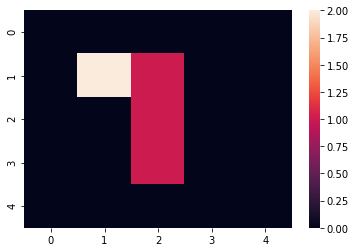



The confusion matrix between coder 2 and coder 6.
[[0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


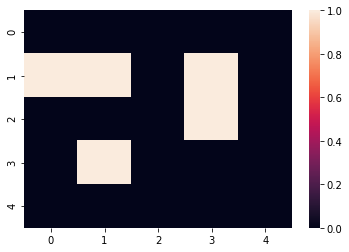



The confusion matrix between coder 2 and coder 7.
[[0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


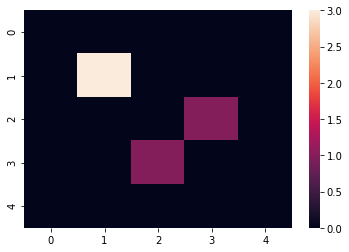



The confusion matrix between coder 2 and coder 8.
[[0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


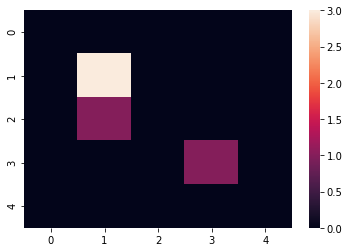



The confusion matrix between coder 3 and coder 4.
[[0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


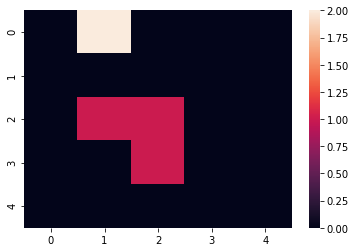



The confusion matrix between coder 3 and coder 5.
[[0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


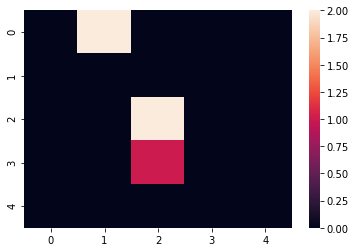



The confusion matrix between coder 3 and coder 6.
[[1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


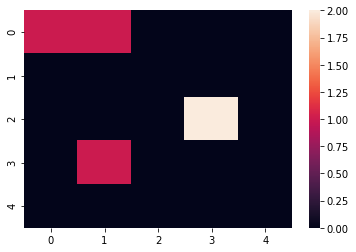



The confusion matrix between coder 3 and coder 7.
[[0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0.]]


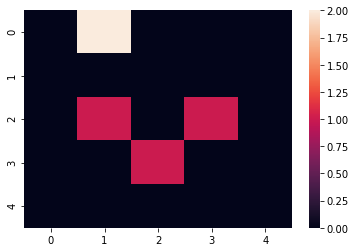



The confusion matrix between coder 3 and coder 8.
[[0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


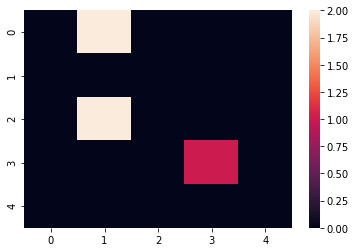



The confusion matrix between coder 4 and coder 5.
[[0. 0. 0. 0. 0.]
 [0. 2. 1. 0. 0.]
 [0. 0. 2. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


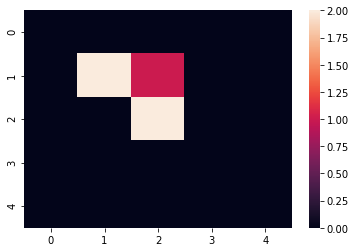



The confusion matrix between coder 4 and coder 6.
[[0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


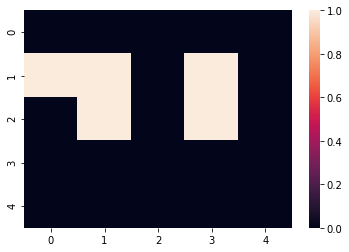



The confusion matrix between coder 4 and coder 7.
[[0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


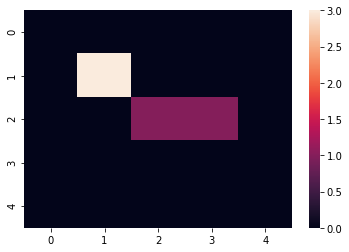



The confusion matrix between coder 4 and coder 8.
[[0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


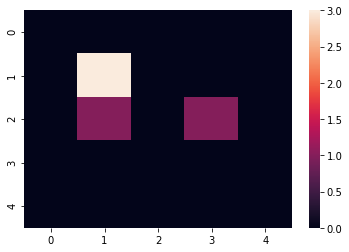



The confusion matrix between coder 5 and coder 6.
[[0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0.]
 [0. 1. 0. 2. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


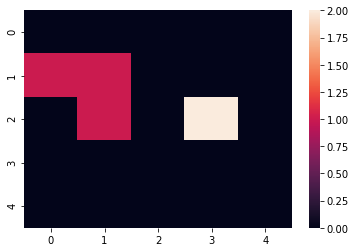



The confusion matrix between coder 5 and coder 7.
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


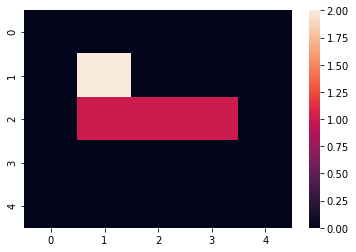



The confusion matrix between coder 5 and coder 8.
[[0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 2. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


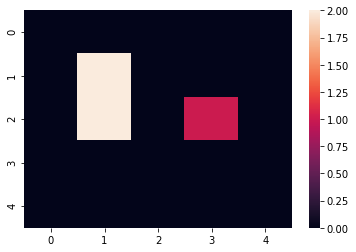



The confusion matrix between coder 6 and coder 7.
[[0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


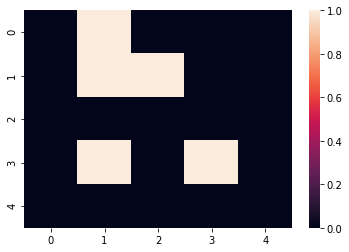



The confusion matrix between coder 6 and coder 8.
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


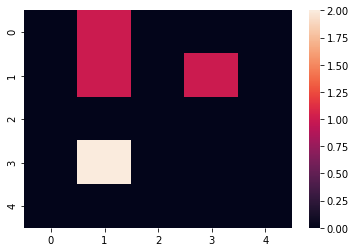



The confusion matrix between coder 7 and coder 8.
[[0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


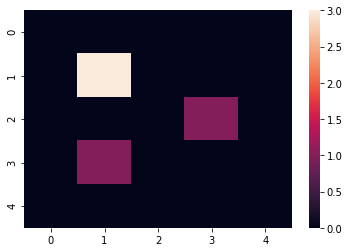

In [37]:
# Obama's speeches responses
for i in range(8):
    for j in range(i + 1, 8):
        print("The confusion matrix between coder {} and coder {}.".format(i+1, j+1))
        coder1 = obama_anno.annotations[:, i]
        coder2 = obama_anno.annotations[:, j]
        confusion_matrix(coder1, coder2, 5)
        print("\n")

In [38]:
# Calculate Scott's pi for each pair of coders
# All speeches responses
for i in range(8):
    for j in range(i + 1, 8):
        print("Scott's pi between coder{} and coder{} is {}.".format(i + 1, j + 1, scotts_pi(response_anno.annotations[:, i], response_anno.annotations[:, j])))

Scott's pi between coder1 and coder2 is 0.6000000000000001.
Scott's pi between coder1 and coder3 is 0.4936708860759494.
Scott's pi between coder1 and coder4 is 0.4405594405594407.
Scott's pi between coder1 and coder5 is 0.12408759124087593.
Scott's pi between coder1 and coder6 is -0.04575163398692811.
Scott's pi between coder1 and coder7 is 0.22580645161290325.
Scott's pi between coder1 and coder8 is 0.3333333333333333.
Scott's pi between coder2 and coder3 is 0.36305732484076436.
Scott's pi between coder2 and coder4 is 0.5620437956204378.
Scott's pi between coder2 and coder5 is 0.2592592592592592.
Scott's pi between coder2 and coder6 is 0.03448275862068976.
Scott's pi between coder2 and coder7 is 0.3197278911564626.
Scott's pi between coder2 and coder8 is 0.7142857142857143.
Scott's pi between coder3 and coder4 is 0.09677419354838715.
Scott's pi between coder3 and coder5 is -0.07382550335570469.
Scott's pi between coder3 and coder6 is 0.09677419354838715.
Scott's pi between coder3 and 

In [39]:
# Calculate Scott's pi for each pair of coders
# Trump's speeches responses
for i in range(8):
    for j in range(i + 1, 8):
        print("Scott's pi between coder{} and coder{} is {}.".format(i + 1, j + 1, scotts_pi(trump_anno.annotations[:, i], trump_anno.annotations[:, j])))

Scott's pi between coder1 and coder2 is 0.7435897435897436.
Scott's pi between coder1 and coder3 is 0.7435897435897436.
Scott's pi between coder1 and coder4 is 0.23076923076923075.
Scott's pi between coder1 and coder5 is -0.08108108108108115.
Scott's pi between coder1 and coder6 is 0.23076923076923075.
Scott's pi between coder1 and coder7 is -0.025641025641025664.
Scott's pi between coder1 and coder8 is 0.47368421052631593.
Scott's pi between coder2 and coder3 is 0.4871794871794872.
Scott's pi between coder2 and coder4 is 0.4594594594594596.
Scott's pi between coder2 and coder5 is 0.14285714285714282.
Scott's pi between coder2 and coder6 is 0.1891891891891892.
Scott's pi between coder2 and coder7 is 0.18918918918918914.
Scott's pi between coder2 and coder8 is 0.7142857142857143.
Scott's pi between coder3 and coder4 is 0.23076923076923075.
Scott's pi between coder3 and coder5 is -0.2820512820512821.
Scott's pi between coder3 and coder6 is 0.23076923076923075.
Scott's pi between coder3 a

In [40]:
# Calculate Scott's pi for each pair of coders
# Obama's speeches responses
for i in range(8):
    for j in range(i + 1, 8):
        print("Scott's pi between coder{} and coder{} is {}.".format(i + 1, j + 1, scotts_pi(obama_anno.annotations[:, i], obama_anno.annotations[:, j])))

Scott's pi between coder1 and coder2 is 0.37500000000000017.
Scott's pi between coder1 and coder3 is 0.14285714285714282.
Scott's pi between coder1 and coder4 is 0.6551724137931035.
Scott's pi between coder1 and coder5 is 0.310344827586207.
Scott's pi between coder1 and coder6 is -0.38888888888888895.
Scott's pi between coder1 and coder7 is 0.37500000000000017.
Scott's pi between coder1 and coder8 is -0.03448275862068969.
Scott's pi between coder2 and coder3 is 0.1891891891891892.
Scott's pi between coder2 and coder4 is 0.6296296296296298.
Scott's pi between coder2 and coder5 is 0.310344827586207.
Scott's pi between coder2 and coder6 is -0.24999999999999994.
Scott's pi between coder2 and coder7 is 0.2857142857142856.
Scott's pi between coder2 and coder8 is 0.565217391304348.
Scott's pi between coder3 and coder4 is -0.1428571428571429.
Scott's pi between coder3 and coder5 is 0.09090909090909091.
Scott's pi between coder3 and coder6 is -0.08108108108108109.
Scott's pi between coder3 and 

There is nothing valuable I can infer from the confusion matrix and Scott's $\pi$ among pair-wise coders using the mixed speeches extracted from Trump and Obama.

However, the pattern becomes clearer when I split the samples into Trump and Obama groups. The facts that in Trump's speeches, the pair-wise confusion matrices are more consistent and that the Scott's $\pi$ are generally larger than that in Obama's group confirm that participants hold relatively similar evaluations about the attitudes in Trump's discourse; whereas survey-takers' opinions are divergent regarding Obama's speeches.

Once again, I can hardly say anything about the reliability of the coding yet since the sample size is too small to jump into a conclusion.


In [41]:
# Calculate Fleiss's kappa
print("Fleiss's kappa in all speeches: ", fleiss_kappa(response_anno.annotations[::]))
print("Fleiss's kappa in Trump's speeches: ", fleiss_kappa(trump_anno.annotations[::]))
print("Fleiss's kappa in Obama's speeches: ", fleiss_kappa(obama_anno.annotations[::]))


Fleiss's kappa in all speeches:  0.2529109285418759
Fleiss's kappa in Trump's speeches:  0.25942857142857145
Fleiss's kappa in Obama's speeches:  0.17448405253283297


Since the coding in the survey is ordinal, I also utilize Krippendorff's $\alpha$ to calculate the agreement metric as follows.

In [42]:
# Calculate Krippendorff's alpha
print("Krippendorff's alpha in all speeches: ", krippendorffs_alpha(response_anno.annotations[::]))
print("Krippendorff's alpha in Trump's speeches: ", krippendorffs_alpha(trump_anno.annotations[::]))
print("Krippendorff's alpha in Obama's speeches: ", krippendorffs_alpha(obama_anno.annotations[::]))

Krippendorff's alpha in all speeches:  0.6543883337834189
Krippendorff's alpha in Trump's speeches:  0.7112369337979094
Krippendorff's alpha in Obama's speeches:  0.5027999523412368


In [43]:
# Define a function that calculates and plots Cohen's Kappa
def cal_cohens_kappa(anno):
    m = pairwise_matrix(cohens_kappa, anno)
    print("The pairwise matrix of Cohen's Kappa is: \n", m)
    
    ax = seaborn.heatmap(m)
    plt.show();
    
    # Calculate the pairwise metric average for the real elements of metric function 
    # run on an array of annotations by calling `pairwise_metric_average`
    print("The average of Cohen's Kappa is {}.".format(pairwise_metric_average(cohens_kappa, anno)))
    
    # Calculate the pairwise metric weighted average of Cohen's kappa
    print("The average of Cohen's weighted Kappa is {}.".format(pairwise_metric_average(cohens_weighted_kappa, anno)))

The pairwise matrix of Cohen's Kappa is: 
 [[ 1.          0.61038961  0.50617284  0.45205479  0.16666667 -0.01265823
   0.24050633  0.35064935]
 [ 0.61038961  1.          0.39759036  0.57142857  0.31506849  0.05405405
   0.32432432  0.71428571]
 [ 0.50617284  0.39759036  1.          0.16666667  0.03614458  0.125
  -0.09756098  0.15662651]
 [ 0.45205479  0.57142857  0.16666667  1.          0.39393939  0.07894737
   0.46666667  0.28571429]
 [ 0.16666667  0.31506849  0.03614458  0.39393939  1.         -0.09756098
   0.34210526  0.31506849]
 [-0.01265823  0.05405405  0.125       0.07894737 -0.09756098  1.
   0.09090909  0.05405405]
 [ 0.24050633  0.32432432 -0.09756098  0.46666667  0.34210526  0.09090909
   1.          0.45945946]
 [ 0.35064935  0.71428571  0.15662651  0.28571429  0.31506849  0.05405405
   0.45945946  1.        ]]


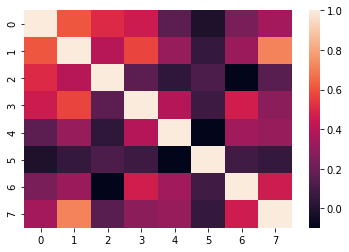

The average of Cohen's Kappa is 0.2666683127480141.
The average of Cohen's weighted Kappa is 0.474531089430252.


In [44]:
# All Speeches
cal_cohens_kappa(response_anno.annotations)

The pairwise matrix of Cohen's Kappa is: 
 [[ 1.00000000e+00  7.50000000e-01  7.50000000e-01  2.50000000e-01
   0.00000000e+00  2.50000000e-01 -3.46944695e-17  5.00000000e-01]
 [ 7.50000000e-01  1.00000000e+00  5.23809524e-01  4.73684211e-01
   2.10526316e-01  2.10526316e-01  2.10526316e-01  7.22222222e-01]
 [ 7.50000000e-01  5.23809524e-01  1.00000000e+00  2.85714286e-01
  -8.69565217e-02  2.85714286e-01 -3.46944695e-17  3.18181818e-01]
 [ 2.50000000e-01  4.73684211e-01  2.85714286e-01  1.00000000e+00
   2.10526316e-01  2.10526316e-01  2.85714286e-01  2.50000000e-01]
 [ 0.00000000e+00  2.10526316e-01 -8.69565217e-02  2.10526316e-01
   1.00000000e+00 -2.50000000e-01  2.50000000e-01  4.11764706e-01]
 [ 2.50000000e-01  2.10526316e-01  2.85714286e-01  2.10526316e-01
  -2.50000000e-01  1.00000000e+00 -3.46944695e-17  2.10526316e-01]
 [-3.46944695e-17  2.10526316e-01 -3.46944695e-17  2.85714286e-01
   2.50000000e-01 -3.46944695e-17  1.00000000e+00  4.44444444e-01]
 [ 5.00000000e-01  7.22222

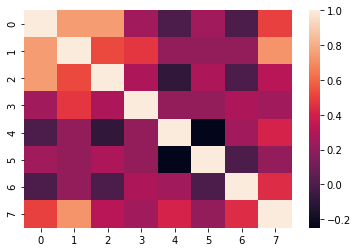

The average of Cohen's Kappa is 0.2741946841145447.
The average of Cohen's weighted Kappa is 0.5221402285197835.


In [45]:
# Trump's Speeches
cal_cohens_kappa(trump_anno.annotations)

The pairwise matrix of Cohen's Kappa is: 
 [[ 1.          0.41176471  0.21052632  0.66666667  0.33333333 -0.25
   0.41176471  0.11764706]
 [ 0.41176471  1.          0.31818182  0.64285714  0.375      -0.17647059
   0.28571429  0.58333333]
 [ 0.21052632  0.31818182  1.          0.04761905  0.21052632  0.04761905
  -0.13636364  0.16666667]
 [ 0.66666667  0.64285714  0.04761905  1.          0.61538462 -0.05263158
   0.64285714  0.23076923]
 [ 0.33333333  0.375       0.21052632  0.61538462  1.          0.04761905
   0.375       0.11764706]
 [-0.25       -0.17647059  0.04761905 -0.05263158  0.04761905  1.
   0.11764706 -0.33333333]
 [ 0.41176471  0.28571429 -0.13636364  0.64285714  0.375       0.11764706
   1.          0.16666667]
 [ 0.11764706  0.58333333  0.16666667  0.23076923  0.11764706 -0.33333333
   0.16666667  1.        ]]


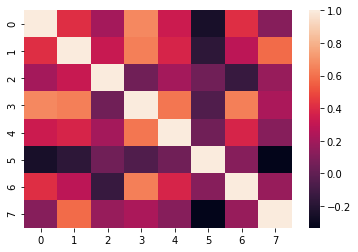

The average of Cohen's Kappa is 0.22121471886509478.
The average of Cohen's weighted Kappa is 0.3691774983822231.


In [46]:
# Obama's Speeches
cal_cohens_kappa(obama_anno.annotations)

No matter Fleiss's Kappa in all speeches, Trump's speeches or Obama's speeches, the statistics are below 0.3, indicating the human annotation is not that reliable. The reasons can be boiled down to the small sample size and the variability among participants.

Since the coding in the survey is ordinal, I also utilized Krippendorff's  𝛼  to calculate the agreement metric as follows.  The statistics in all speeches, Trump's speeches and Obama's speeches are 0.654, 0.711 and 0.503 respectively, which are higher than Fleiss's Kappa. It coincides with my previous hypothesis that survey-takers'  assessments in Trump's speeches are more reliable than that in Obama's speeches. Such a discrepancy between the coders' evaluation of Trump's and Obama's speeches is reasonable because Trump prefers to use plain and explicit words, such as "thief", to express opinions while Obama's wordings are more complex to understand.

# Models

However, what if some coders are better than others. **The prior measures all rely on the assumption that all coders are equally good.** What if some are worse than others? Now we use Rzhetsky et al (2009) and Dawid & Skene's models to make inference about true label classes by downweighting bad or deviant coders. Pyanno provides three relevant models: ModelA, ModelB, and ModelBt. **Model A** can only be currently run on a balanced 8-coder design, but assesses accuracy purely based on agreement. **Model B** with $\theta$s models the relationship between each coder and code. **Model Bt** is the Dawid & Skene model from the reading. The following image schematically suggests the relationship between the models. <img src="../data/models.png">

The models should provide similar results. To estimate the parameters for any models, we first need to create a new model. 

In [47]:
# create a new instance of model A, with 4 label classes
model = ModelB.create_initial_state(4, 8)
# other model parameters are initialized from the model prior
print(model.theta)
print("-" * 20)
print(model.log_likelihood(anno.annotations))

[[[6.29789885e-01 1.63639590e-01 2.05751725e-01 8.18800368e-04]
  [1.40970552e-01 4.03115882e-01 6.71874982e-02 3.88726068e-01]
  [5.29330858e-02 1.15160579e-01 6.62940633e-01 1.68965701e-01]
  [7.94056817e-02 1.11031982e-01 4.81385896e-02 7.61423747e-01]]

 [[7.25006862e-01 2.26800912e-01 4.42558715e-02 3.93635422e-03]
  [1.02724463e-01 6.05511138e-01 1.55902109e-01 1.35862290e-01]
  [4.62171634e-02 1.42800737e-01 6.20161244e-01 1.90820855e-01]
  [2.43570176e-02 1.10278825e-01 1.28723160e-01 7.36640998e-01]]

 [[7.46903358e-01 1.61368994e-01 4.61129023e-02 4.56147465e-02]
  [1.39402325e-01 7.27102016e-01 7.99103040e-02 5.35853548e-02]
  [1.77779219e-01 5.08135179e-02 6.52130291e-01 1.19276972e-01]
  [7.14071147e-04 7.16764466e-02 1.11768039e-01 8.15841443e-01]]

 [[7.24900701e-01 1.75174191e-01 6.83999711e-02 3.15251365e-02]
  [1.15205919e-01 6.38907562e-01 7.79431499e-02 1.67943369e-01]
  [3.32809214e-02 1.42333867e-01 7.06374833e-01 1.18010378e-01]
  [6.83516369e-03 1.09723920e-01 2

In [48]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [49]:
help(model.sample_posterior_over_accuracy)

Help on method sample_posterior_over_accuracy in module pyanno.modelB:

sample_posterior_over_accuracy(annotations, nsamples, burn_in_samples=0, thin_samples=1, return_all_samples=True) method of pyanno.modelB.ModelB instance
    Return samples from posterior distribution over theta given data.
    
    Samples are drawn using Gibbs sampling, i.e., alternating between
    sampling from the conditional distribution of theta given the
    annotations and the label classes, and sampling from the conditional
    distribution of the classes given theta and the annotations.
    
    This results in a fast-mixing sampler, and so the parameters
    controlling burn-in and thinning can be set to a small number
    of samples.
    
    Arguments
    ----------
    annotations : ndarray, shape = (n_items, n_annotators)
        annotations[i,j] is the annotation of annotator j for item i
    
    nsamples : int
        number of samples to draw from the posterior
    
    burn_in_samples : int
   

Pyanno allows one to use either **MLE (maximum likelihood estimation)** or **MAP (maximum a posteriori estimation)** to estimate model parameters. Note that the parameters here correspond to our estimation of the accuracy of each annotator.

In [50]:
model.map(anno.annotations)
print(model.theta)
print("-" * 20)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

In [51]:
# Computes maximum a posteriori (MAP) estimation of parameters.
model = ModelB.create_initial_state(4, 8)
model.map(anno.annotations)
print(model.theta)
print("-" * 20)
print(model.log_likelihood(anno.annotations))

[[[7.73398728e-01 2.01020245e-01 2.55810269e-02 1.20101219e-26]
  [1.47832659e-01 7.11503767e-01 7.66499157e-02 6.40136580e-02]
  [1.97431020e-02 1.48708709e-01 6.96639326e-01 1.34908863e-01]
  [2.52463780e-18 2.13647377e-02 8.51550428e-02 8.93480220e-01]]

 [[7.19395465e-01 2.01828761e-01 7.87757734e-02 1.55486964e-13]
  [1.33941799e-01 7.07223261e-01 1.10418200e-01 4.84167403e-02]
  [2.72093282e-02 1.65178369e-01 6.71232700e-01 1.36379603e-01]
  [2.15358721e-30 5.38211823e-02 1.21871740e-01 8.24307077e-01]]

 [[8.50073137e-01 1.22955501e-01 2.69713621e-02 3.64395738e-42]
  [8.93514251e-02 7.89280333e-01 8.93429608e-02 3.20252811e-02]
  [6.11638366e-02 1.29121422e-01 7.03992731e-01 1.05722011e-01]
  [6.53666390e-03 5.12606512e-02 2.10869595e-01 7.31333090e-01]]

 [[6.99612801e-01 2.70976969e-01 2.94102301e-02 8.57899704e-52]
  [9.67171336e-02 7.62615701e-01 1.09523823e-01 3.11433425e-02]
  [1.81150586e-02 1.45472330e-01 6.85587954e-01 1.50824657e-01]
  [2.71897111e-47 2.98511124e-02 2

In [52]:
help(model.map)

Help on method map in module pyanno.modelB:

map(annotations, epsilon=1e-05, init_accuracy=0.6, max_epochs=1000) method of pyanno.modelB.ModelB instance
    Computes maximum a posteriori (MAP) estimation of parameters.
    
    Estimate the parameters :attr:`theta` and :attr:`pi` from a set of
    observed annotations using maximum a posteriori estimation.
    
    Arguments
    ----------
    annotations : ndarray, shape = (n_items, n_annotators)
        annotations[i,j] is the annotation of annotator j for item i
    
    epsilon : float
        The estimation is interrupted when the objective function has
        changed less than `epsilon` on average over the last 10 iterations
    
    initial_accuracy : float
        Initialize the accuracy parameters, `theta` to a set of
        distributions where theta[j,k,k'] = initial_accuracy if k==k',
        and (1-initial_accuracy) / (n_classes - 1)
    
    max_epoch : int
        Interrupt the estimation after `max_epoch` iterations



Once we have model parameters estimated, we can now make inferences about the true label classes. We can calculate **the posterior distribution** over the true label classes.

In [53]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[1.20741380e-42 1.00240780e-01 7.90821679e-01 1.08937540e-01]
 [9.92682453e-01 7.07056554e-03 2.46981317e-04 2.03944498e-49]
 [1.07420297e-03 5.51435353e-02 9.37476514e-01 6.30574822e-03]
 ...
 [8.15378491e-04 3.51193436e-02 9.59859130e-01 4.20614824e-03]
 [1.34481992e-44 2.14447325e-03 9.16166870e-01 8.16886569e-02]
 [2.14745550e-01 7.69057353e-01 1.61970966e-02 2.01807019e-26]]


Let's turn the posterior of the first 100 samples into a heatmap.

In [54]:
votes = []
for r in anno.annotations:
    v = [0] * len(anno.labels)
    votes.append(v)
    for a in r:
        if a > -1:
            v[a] += 1
votes_array = np.array(votes)
print(anno.annotations)
print("-" * 20)
print(votes_array)

[[ 1  2  3 ... -1 -1 -1]
 [ 0  0  0 ... -1 -1 -1]
 [ 2  2  1 ... -1 -1 -1]
 ...
 [ 2  2 -1 ... -1 -1  1]
 [ 2  2 -1 ... -1 -1  3]
 [ 1  1 -1 ... -1 -1  0]]
--------------------
[[0 1 1 1]
 [3 0 0 0]
 [0 1 2 0]
 ...
 [0 1 2 0]
 [0 0 2 1]
 [1 2 0 0]]


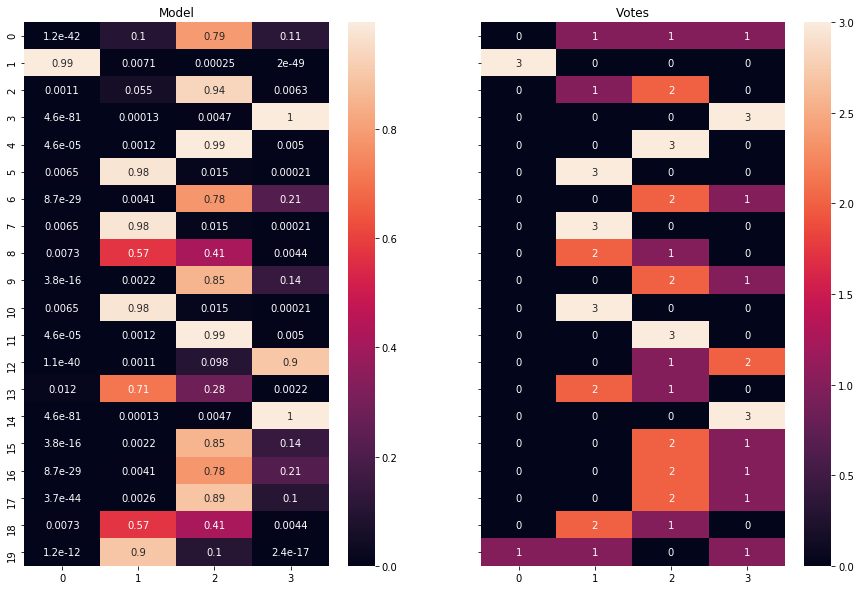

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15, 10), sharey=True)
num_questions = 20

seaborn.heatmap(votes_array[:num_questions], annot = True, ax=ax2)
seaborn.heatmap(posterior[:num_questions], annot=True, ax =ax1)
ax1.set_title("Model")
ax2.set_title("Votes")
plt.show()

This differs markedly from taking annotator scores at face value (Add comparison of average values)

In [56]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)

In [57]:
print(samples[0].mean(axis=0))
print("-" * 50)
print(samples[0].std(axis=0))

[[[0.73327914 0.20089997 0.04549145 0.02032944]
  [0.14616543 0.69172476 0.09130834 0.07080147]
  [0.03047027 0.15910199 0.67785271 0.13257503]
  [0.01224101 0.03070577 0.10262984 0.85442337]]

 [[0.67540428 0.1995066  0.09494633 0.03014278]
  [0.14191605 0.69187104 0.11693964 0.04927327]
  [0.03184636 0.16858267 0.66215401 0.13741696]
  [0.00981058 0.0662009  0.13092504 0.79306348]]

 [[0.78655568 0.14393033 0.04926984 0.02024414]
  [0.10417115 0.74797871 0.10544971 0.04240043]
  [0.06752274 0.13410625 0.6923229  0.10604811]
  [0.01633405 0.06524858 0.22073388 0.69768349]]

 [[0.6564157  0.27098486 0.05324273 0.01935671]
  [0.09990989 0.73768461 0.12005273 0.04235277]
  [0.0272249  0.1536802  0.66879821 0.15029668]
  [0.00794102 0.03696139 0.24157022 0.71352737]]

 [[0.76273838 0.13521145 0.08470668 0.01734349]
  [0.12900966 0.66879059 0.15450465 0.0476951 ]
  [0.01989332 0.21113945 0.6380703  0.13089693]
  [0.00811138 0.07251587 0.18840204 0.73097071]]

 [[0.73036871 0.20959497 0.043

Let's try everything again with ModelBt

In [58]:
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print("-" * 20)
print(model.log_likelihood(anno.annotations))

[0.89826018 0.92522882 0.82397332 0.72405432 0.80048581 0.80744277
 0.7227846  0.71579601]
--------------------
-3008.255816774476


In [59]:
model.map(anno.annotations)
print(model.theta)
print("-" * 20)
print(model.log_likelihood(anno.annotations))

[0.79142207 0.74062405 0.76216446 0.72497225 0.71652997 0.71874989
 0.77299541 0.71666724]
--------------------
-2811.9460169800154


In [60]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[0.01111267 0.28974839 0.3645755  0.33456345]
 [0.99022703 0.00241954 0.00404549 0.00330794]
 [0.0025025  0.05510725 0.93455341 0.00783684]
 ...
 [0.0025319  0.04400778 0.94553143 0.0079289 ]
 [0.00249687 0.00571922 0.93244983 0.05933408]
 [0.03189646 0.93884185 0.01609831 0.01316338]]


Let's visualize the posterior of the first 10 samples according to ModelBt.

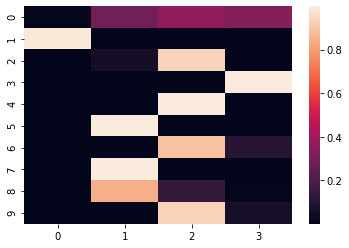

In [61]:
ax = seaborn.heatmap(posterior[:10,])
plt.show()

The property of these scores is that **they enable us to identify the most likely code assuming coders of unequal quality, which also allows us to break ties when we know coder identity.** For some analyses, we may simply use the posterior themselves rather than the most probably code outcome.

# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [62]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99, 0.75, 0.25])
#randomly generate annotations with 4 label classes and 3 annotators. 
# The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

array([[3, 3, 0],
       [1, 1, 3],
       [0, 0, 1],
       [3, 3, 1],
       [1, 0, 3],
       [2, 1, 3],
       [1, 1, 2],
       [0, 0, 3],
       [3, 3, 1],
       [2, 0, 0],
       [3, 3, 3],
       [3, 3, 1],
       [2, 2, 3],
       [1, 3, 1],
       [0, 0, 0],
       [3, 3, 0],
       [3, 3, 2],
       [3, 3, 1],
       [3, 3, 1],
       [3, 2, 0]])

## Visualizing coder accuracy

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipython notebooks. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [63]:
model = ModelBt.create_initial_state(4, 8)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)#.mean(axis = 1).mean(axis = 1)
y_ci = samples.std(axis=0)#.mean(axis = 1).mean(axis = 1)

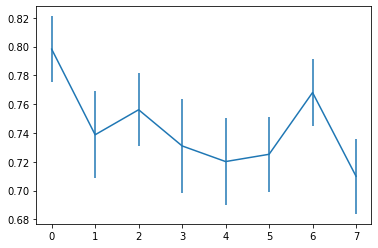

In [64]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()

# Example with articles that use the General Social Survey

I performed a recent study in which the variables from thousands of articles were associated with those used in the General Social Survey, a widely used population sample, in order to interrogate **how social science analyses are performed**. Each article was reread and coded by a balanced set of three student coders using a 6 choose 3 design, such that all possible 3-coder-subsets (20) coded an equal number of articles. Coding was performed through a website that allowed students access to the digital article. To evaluate the validity of the student codes, we also recruited a sample of authors associated with 97 of our published articles to fill out the same online survey. 

Because not all coders coded items with equal accuracy, and because “don’t know” was an optional answer, leading to potential ties, we used a generative, probabilistic model to estimate the maximum a posteriori probability (MAP) prediction that an item’s code is true, which integrates over the estimated accuracy of coders, assuming only that the entire population of coders is slightly more often right than wrong. The model (“Model B”) is based on a simple underlying generation process that directly accounts for the probability that coded values are correct (Rzhetsky et al. 2009). For each coded value j, a set of parameters, denoted γj, **represents the probability that each coded value is correct**. For the ith coder (i = 1, 2, …, 6), we introduce a matrix of probabilities, denoted λ(i)x|y, that defines the probability that she assigns code x (e.g., Dependent variable) to a GSS variable with correct annotation y. For a perfect coder, the matrix λ(i)x|y would equal the identity matrix and her vote would count most toward the total. For a coder that always codes incorrectly—a “troll”—her matrix λ(i)x|y will have all its value off the diagonal and will only minimally influence the posterior. We co-authored the open source pyanno software that implements this model.

Getting the data for each content analysis survey regarding how GSS variables were used in a large population of social science articles.

In [65]:
#anno_vdep = AnnotationsContainer.from_file(missing_values=[-1], filename="GSSvariable_testSdependent.csv")
dev = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSdependent.csv", dtype=int, delimiter=",")
anno_dv = AnnotationsContainer.from_array(dev)

ind = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testSindependent.csv", dtype=int, delimiter=",")
anno_iv = AnnotationsContainer.from_array(ind)

cent = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScentral.csv", dtype=int, delimiter=",")
anno_cv = AnnotationsContainer.from_array(cent)

cont = np.loadtxt(fname="../data/dataforgssstudy/n7GSSvariable_testScontrol.csv", dtype=int, delimiter=",")
anno_ctv = AnnotationsContainer.from_array(cont)

test = np.loadtxt(fname="../data/dataforgssstudy/testH.csv", dtype=int, delimiter=",")
anno_test = AnnotationsContainer.from_array(test)

Let's examine the data structure.

In [66]:
dev

array([[ 0, -1, -1,  1, -1,  1],
       [ 0, -1, -1,  0, -1,  0],
       [ 0, -1, -1,  1, -1,  0],
       ...,
       [-1, -1, -1, -1,  0, -1],
       [-1, -1, -1, -1,  0, -1],
       [-1, -1, -1, -1,  0, -1]])

In [67]:
dev.shape

(21461, 6)

In [68]:
anno_dv.labels

[0, 1]

In [69]:
anno_dv.missing_values

[-1]

In [70]:
anno_dv.annotations.shape

(21461, 6)

First, let's use Cohen's $\kappa$ to measure agreement between coders...

In [71]:
m = pairwise_matrix(cohens_kappa, anno_dv.annotations)
print(m)

[[1.         0.62426874 0.46682841 0.44599604 0.16569888 0.36657805]
 [0.62426874 1.         0.53480937 0.52673854 0.3306905  0.59513211]
 [0.46682841 0.53480937 1.         0.50580068 0.42393752 0.49833997]
 [0.44599604 0.52673854 0.50580068 1.         0.46517493 0.47023754]
 [0.16569888 0.3306905  0.42393752 0.46517493 1.         0.66190749]
 [0.36657805 0.59513211 0.49833997 0.47023754 0.66190749 1.        ]]


Let's visualize that...

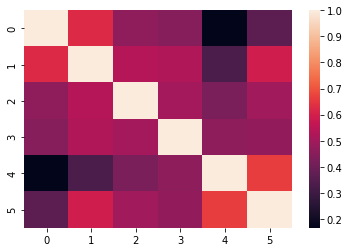

In [72]:
ax = seaborn.heatmap(m)
plt.show()

In [73]:
pairwise_metric_average(cohens_kappa, anno_dv.annotations)

0.4721425844540702

Let's compute the statistics on each of the datasets and with Pearson's $\rho$. 

In [74]:
datasets = [anno_dv.annotations, anno_iv.annotations, anno_cv.annotations, anno_ctv.annotations]
ck = [pairwise_matrix(cohens_kappa, anno) for anno in datasets]
pr = [pairwise_matrix(pearsons_rho, anno) for anno in datasets]
titles = ['DV', 'IV', 'Central Variable', "Control Variable"]

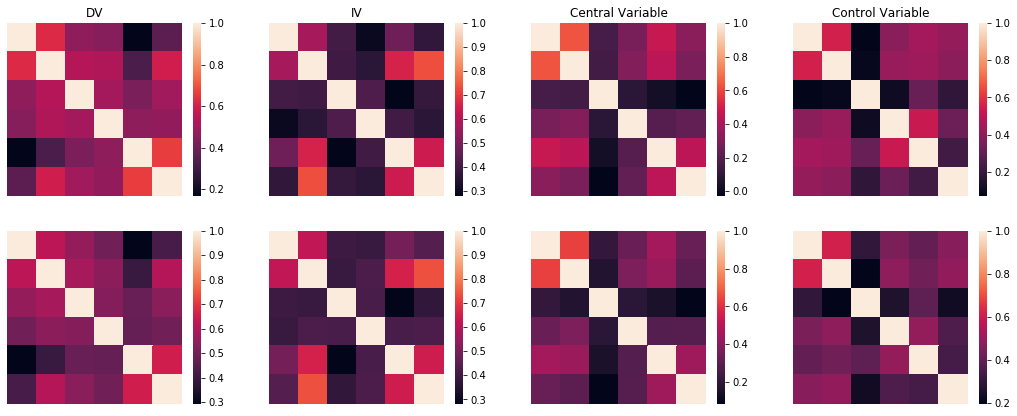

In [75]:
fig, axs = plt.subplots(2,4)
fig.set_size_inches(18, 7)
for k, ax, title in zip(ck,axs[0], titles):
    seaborn.heatmap(k, ax = ax)
    ax.set_title(title)
    ax.set_xticks(())
    ax.set_yticks(())
for r, ax in zip(pr,axs[1]):
    seaborn.heatmap(r, ax = ax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

Now we will compare the student coders.

In [76]:
nondiag = (np.eye(6)-np.ones(6))*-1.0

In [77]:
xdevck = pairwise_matrix(cohens_kappa, anno_dv.annotations)
xdevpr = pairwise_matrix(pearsons_rho, anno_dv.annotations)

xindck = pairwise_matrix(cohens_kappa, anno_iv.annotations)
xindpr = pairwise_matrix(pearsons_rho, anno_iv.annotations)

xcenck = pairwise_matrix(cohens_kappa, anno_cv.annotations)
xcenpr = pairwise_matrix(pearsons_rho, anno_cv.annotations)

xconck = pairwise_matrix(cohens_kappa, anno_ctv.annotations)
xconpr = pairwise_matrix(pearsons_rho, anno_ctv.annotations)

print(np.average(xdevck, weights=nondiag))
print(np.average(xdevpr, weights=nondiag))
print(np.average(xindck, weights=nondiag))
print(np.average(xindpr, weights=nondiag))
print(np.average(xcenck, weights=nondiag))
print(np.average(xcenpr, weights=nondiag))
print(np.average(xconck, weights=nondiag))
print(np.average(xconpr, weights=nondiag))

0.47214258445407015
0.5142407278222342
0.4529627823703711
0.47596526866863437
0.27082376869768193
0.31514049828362706
0.32833477875850064
0.3945852779196347


Now we are going to bring in "gold standard" data. In this case, this is where we asked authors of the articles to code their own article's variables and compare with our student coders.

In [78]:
mergedata = np.loadtxt(fname="../data/dataforgssstudy/gss_mergedataC.txt", dtype=int, delimiter="\t")

In [79]:
anno_merge_dep = AnnotationsContainer.from_array(mergedata[:,0:2])
anno_merge_ind = AnnotationsContainer.from_array(mergedata[:,2:4])
anno_merge_cen = AnnotationsContainer.from_array(mergedata[:,4:6])
anno_merge_con = AnnotationsContainer.from_array(mergedata[:,6:8])
anno_merge_dkn = AnnotationsContainer.from_array(mergedata[:,8:10])

In [80]:
print("""Dependent variable -- kappa & rho""")
print(cohens_kappa(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))
print(pearsons_rho(anno_merge_dep.annotations[:,0], anno_merge_dep.annotations[:,1]))

print("\nIndependent variable")
print(cohens_kappa(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))
print(pearsons_rho(anno_merge_ind.annotations[:,0], anno_merge_ind.annotations[:,1]))

print("\nCentral variable")
print(cohens_kappa(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))
print(pearsons_rho(anno_merge_cen.annotations[:,0], anno_merge_cen.annotations[:,1]))

print("\nControl variable")
print(cohens_kappa(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))
print(pearsons_rho(anno_merge_con.annotations[:,0], anno_merge_con.annotations[:,1]))

Dependent variable -- kappa & rho
0.3744311057948666
0.38563437203620615

Independent variable
0.5430690164641346
0.5529974941771468

Central variable
-0.064017189548477
-0.08887644319259187

Control variable
0.2815172499181942
0.28239237574620263


Whoah! Student coders and authors viewed articles that were "central" or critical to the published argument as fundamentally different (exhibiting negative agreement and correlation). Why? Likely because that researchers recalled what they had _intended_ as their central variables before analysis, but those that _worked out_ became central in the text.

Now for the assessment of the relative values of authors, then student coders.

In [81]:
print("Dependent")
print(np.average(anno_merge_dep.annotations[:,0]))
print(np.average(anno_merge_dep.annotations[:,1]))

print("\nIndependent")
print(np.average(anno_merge_ind.annotations[:,0]))
print(np.average(anno_merge_ind.annotations[:,1]))

print("\nCentral")
print(np.average(anno_merge_cen.annotations[:,0]))
print(np.average(anno_merge_cen.annotations[:,1]))

print("\nControl")
print(np.average(anno_merge_con.annotations[:,0]))
print(np.average(anno_merge_con.annotations[:,1]))

Dependent
0.4763912310286678
0.35834738617200673

Independent
0.23777403035413153
0.3136593591905565

Central
0.35328836424957843
0.7512647554806071

Control
0.081787521079258
0.09443507588532883


## Now we are going to use models to predict the correct annotations

Recall that Model A is built for 8 coders, but we have 6. We're going to *hack* it by adding two blank columns.

In [82]:
dev.shape

(21461, 6)

In [83]:
negs2 = np.ones((21461, 2), dtype=np.int)*(-1)
negs2

array([[-1, -1],
       [-1, -1],
       [-1, -1],
       ...,
       [-1, -1],
       [-1, -1],
       [-1, -1]])

In [84]:
devA = np.concatenate((dev, negs2), axis=1)
devA

array([[ 0, -1, -1, ...,  1, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       [ 0, -1, -1, ...,  0, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [85]:
anno_dvA = AnnotationsContainer.from_array(devA)
model_devA = ModelA.create_initial_state(2)
model_devA.theta

array([0.76530561, 0.92398266, 0.85789048, 0.78577714, 0.90405049,
       0.78298842, 0.8481339 , 0.94542144])

In [86]:
model_dvB = ModelB.create_initial_state(2, 6)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[0.52567067 0.47432933]
-30691.956751471298


In [87]:
model_dvB.map(anno_dv.annotations)
print(model_dvB.pi)
print(model_dvB.log_likelihood(anno_dv.annotations))

[0.69455487 0.30544513]
-25462.473635032595


In [88]:
# compute the posterior distribution over true annotations
posterior_dvB = model_dvB.infer_labels(anno_dv.annotations)
# each row show the probability of each label class for the
# corresponding item
print(posterior)

[[0.01111267 0.28974839 0.3645755  0.33456345]
 [0.99022703 0.00241954 0.00404549 0.00330794]
 [0.0025025  0.05510725 0.93455341 0.00783684]
 ...
 [0.0025319  0.04400778 0.94553143 0.0079289 ]
 [0.00249687 0.00571922 0.93244983 0.05933408]
 [0.03189646 0.93884185 0.01609831 0.01316338]]


In [89]:
samples_dvB = model_dvB.sample_posterior_over_accuracy(anno_dv.annotations, 200, burn_in_samples=100, thin_samples=3)

In [90]:
# we can then compute a credible interval for the parameters:
ci_dv_mean = samples_dvB[0].mean(axis=0)
print("Mean")
print(ci_dv_mean)

print("\n", "-" * 30)

ci_dv_stdev = samples_dvB[0].std(axis=0)
print("\nSTD")
print(ci_dv_stdev)

Mean
[[[0.97907002 0.02092998]
  [0.51600207 0.48399793]]

 [[0.96881522 0.03118478]
  [0.26152888 0.73847112]]

 [[0.98302736 0.01697264]
  [0.34536539 0.65463461]]

 [[0.93554662 0.06445338]
  [0.23948638 0.76051362]]

 [[0.69308117 0.30691883]
  [0.04595584 0.95404416]]

 [[0.86473857 0.13526143]
  [0.0692502  0.9307498 ]]]

 ------------------------------

STD
[[[0.00229183 0.00229183]
  [0.01140809 0.01140809]]

 [[0.00324347 0.00324347]
  [0.0155471  0.0155471 ]]

 [[0.0030549  0.0030549 ]
  [0.0137049  0.0137049 ]]

 [[0.0044969  0.0044969 ]
  [0.01160092 0.01160092]]

 [[0.00706071 0.00706071]
  [0.00504597 0.00504597]]

 [[0.0069948  0.0069948 ]
  [0.00708182 0.00708182]]]


We will use Model B estimates for other variable assessments.

In [91]:
#test
model_testB = ModelB.create_initial_state(2, 6)
print("model_testB.log_likelihood: ", model_testB.log_likelihood(anno_test.annotations))
model_testB.map(anno_test.annotations)
print("model_testB.pi: ", model_testB.pi)
print("model_testB.log_likelihood: ", model_testB.log_likelihood(anno_test.annotations))
print("anno_test.annotations.shape: ", anno_test.annotations.shape)

posterior_testB = model_testB.infer_labels(anno_test.annotations)
print("posterior_testB.shape: ", posterior_testB.shape)
samples_testB = model_testB.sample_posterior_over_accuracy(anno_test.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_test_mean = samples_testB[0].mean(axis=0)
print("ci_test_mean: ", ci_test_mean)

model_testB.log_likelihood:  -143.71612717497172
model_testB.pi:  [9.20933481e-20 1.00000000e+00]
model_testB.log_likelihood:  -48.9756711393957
anno_test.annotations.shape:  (48, 6)
posterior_testB.shape:  (48, 2)
ci_test_mean:  [[[0.79696084 0.20303916]
  [0.13335083 0.86664917]]

 [[0.80024958 0.19975042]
  [0.08659659 0.91340341]]

 [[0.80327777 0.19672223]
  [0.50387576 0.49612424]]

 [[0.79396734 0.20603266]
  [0.07107902 0.92892098]]

 [[0.80941967 0.19058033]
  [0.36808358 0.63191642]]

 [[0.80132315 0.19867685]
  [0.12721141 0.87278859]]]


In [92]:
#indepedent variables
model_ivB = ModelB.create_initial_state(2, 6)
print(model_ivB.log_likelihood(anno_iv.annotations))
model_ivB.map(anno_iv.annotations)
print(model_ivB.pi)
print(model_ivB.log_likelihood(anno_iv.annotations))
print(anno_iv.annotations.shape)
posterior_ivB = model_ivB.infer_labels(anno_iv.annotations)
print(posterior_ivB.shape)
samples_ivB = model_ivB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_iv_mean = samples_ivB[0].mean(axis=0)
print(ci_iv_mean)

-34473.81124706856
[0.61093546 0.38906454]
-28620.66523246587
(21461, 6)
(21461, 2)
[[[0.97101689 0.02898311]
  [0.34815248 0.65184752]]

 [[0.93744294 0.06255706]
  [0.05293013 0.94706987]]

 [[0.65860738 0.34139262]
  [0.21016981 0.78983019]]

 [[0.53613796 0.46386204]
  [0.03059397 0.96940603]]

 [[0.87515896 0.12484104]
  [0.09881445 0.90118555]]

 [[0.89108121 0.10891879]
  [0.09026014 0.90973986]]]


In [93]:
#central variables
model_cvB = ModelB.create_initial_state(2, 6)
print(model_cvB.log_likelihood(anno_cv.annotations))
model_cvB.map(anno_cv.annotations)
print(model_cvB.pi)
print(model_cvB.log_likelihood(anno_cv.annotations))
print(anno_cv.annotations.shape)
posterior_cvB = model_cvB.infer_labels(anno_cv.annotations)
print(posterior_cvB.shape)
samples_cvB = model_cvB.sample_posterior_over_accuracy(anno_cv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_cv_mean = samples_cvB[0].mean(axis=0)
print(ci_cv_mean)

-41940.54824527366
[0.23988844 0.76011156]
-25034.918555765576
(21461, 6)
(21461, 2)
[[[0.88605855 0.11394145]
  [0.06882394 0.93117606]]

 [[0.7785302  0.2214698 ]
  [0.05639223 0.94360777]]

 [[0.99189605 0.00810395]
  [0.8421533  0.1578467 ]]

 [[0.94994359 0.05005641]
  [0.45505915 0.54494085]]

 [[0.67110147 0.32889853]
  [0.05539166 0.94460834]]

 [[0.5889208  0.4110792 ]
  [0.09467096 0.90532904]]]


In [94]:
#control variables
model_ctvB = ModelB.create_initial_state(2, 6)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
model_ctvB.map(anno_ctv.annotations)
print(model_ctvB.pi)
print(model_ctvB.log_likelihood(anno_ctv.annotations))
print(anno_ctv.annotations.shape)
posterior_ctvB = model_ctvB.infer_labels(anno_ctv.annotations)
print(posterior_ctvB.shape)
samples_ctvB = model_ctvB.sample_posterior_over_accuracy(anno_iv.annotations, 200, burn_in_samples=100, thin_samples=3)
ci_ctv_mean = samples_ctvB[0].mean(axis=0)
print(ci_ctv_mean)

-27035.50933930165
[0.83068326 0.16931674]
-19415.702035242168
(21461, 6)
(21461, 2)
[[[0.97049158 0.02950842]
  [0.3488242  0.6511758 ]]

 [[0.93682567 0.06317433]
  [0.05349008 0.94650992]]

 [[0.65801482 0.34198518]
  [0.21143051 0.78856949]]

 [[0.53736372 0.46263628]
  [0.03038679 0.96961321]]

 [[0.87493289 0.12506711]
  [0.09953856 0.90046144]]

 [[0.89077633 0.10922367]
  [0.08960221 0.91039779]]]


Now we will package up the predicted data into a format we can use for other, subsequent analysis:

In [95]:
print(posterior_dvB.shape)
print(posterior_ivB.shape)
print(posterior_cvB.shape)
print(posterior_ctvB.shape)

(21461, 2)
(21461, 2)
(21461, 2)
(21461, 2)


In [96]:
predicted_annotations = np.concatenate((posterior_dvB, posterior_ivB, posterior_cvB, posterior_ctvB), axis=1) 
# posterior_dvBt, posterior_ivBt, posterior_cvBt, posterior_ctvBt), axis=1)

In [97]:
predicted_annotations.shape

(21461, 8)

These annotations allowed us to uncover the degree to which social scientists alter their models to achieve a better fit...undocumented data mining. The answer was that social scientists did mine their data, but that it likely improved their analysis because change in the social world was the result of greater distortion than undocumented data mining.

## Another example analysis looks at a different data set of Hotel Reviews by a variety of patrons.

In [98]:
df_hotels = pandas.read_csv('../data/hot_Reviews.csv', index_col=0)
df_hotels[:5]

,Karen,Scott,Jessica,write a review,A verified traveler,Kevin,William,R,S,Christopher,...,Thomas,Susan,A Traveler,M,Not Provided,B,Laura,xxxxxxxxxxxxxx,Michael,Joseph
1785 Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1900 House,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Bed & Breakfast In Cambridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A Swallow's Nest Motel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Abbeville Inn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here a rank of 0 is a missing value and to simplify things more we will convert from a 1-10 scale to a 1-5 scale, with 0 as missing

In [99]:
#integer divide by 2 rounds all values
df_hotels = df_hotels.apply(lambda x: x // 2) 

And we can visualize all the reviews as a heatmap with the missing values greyed out

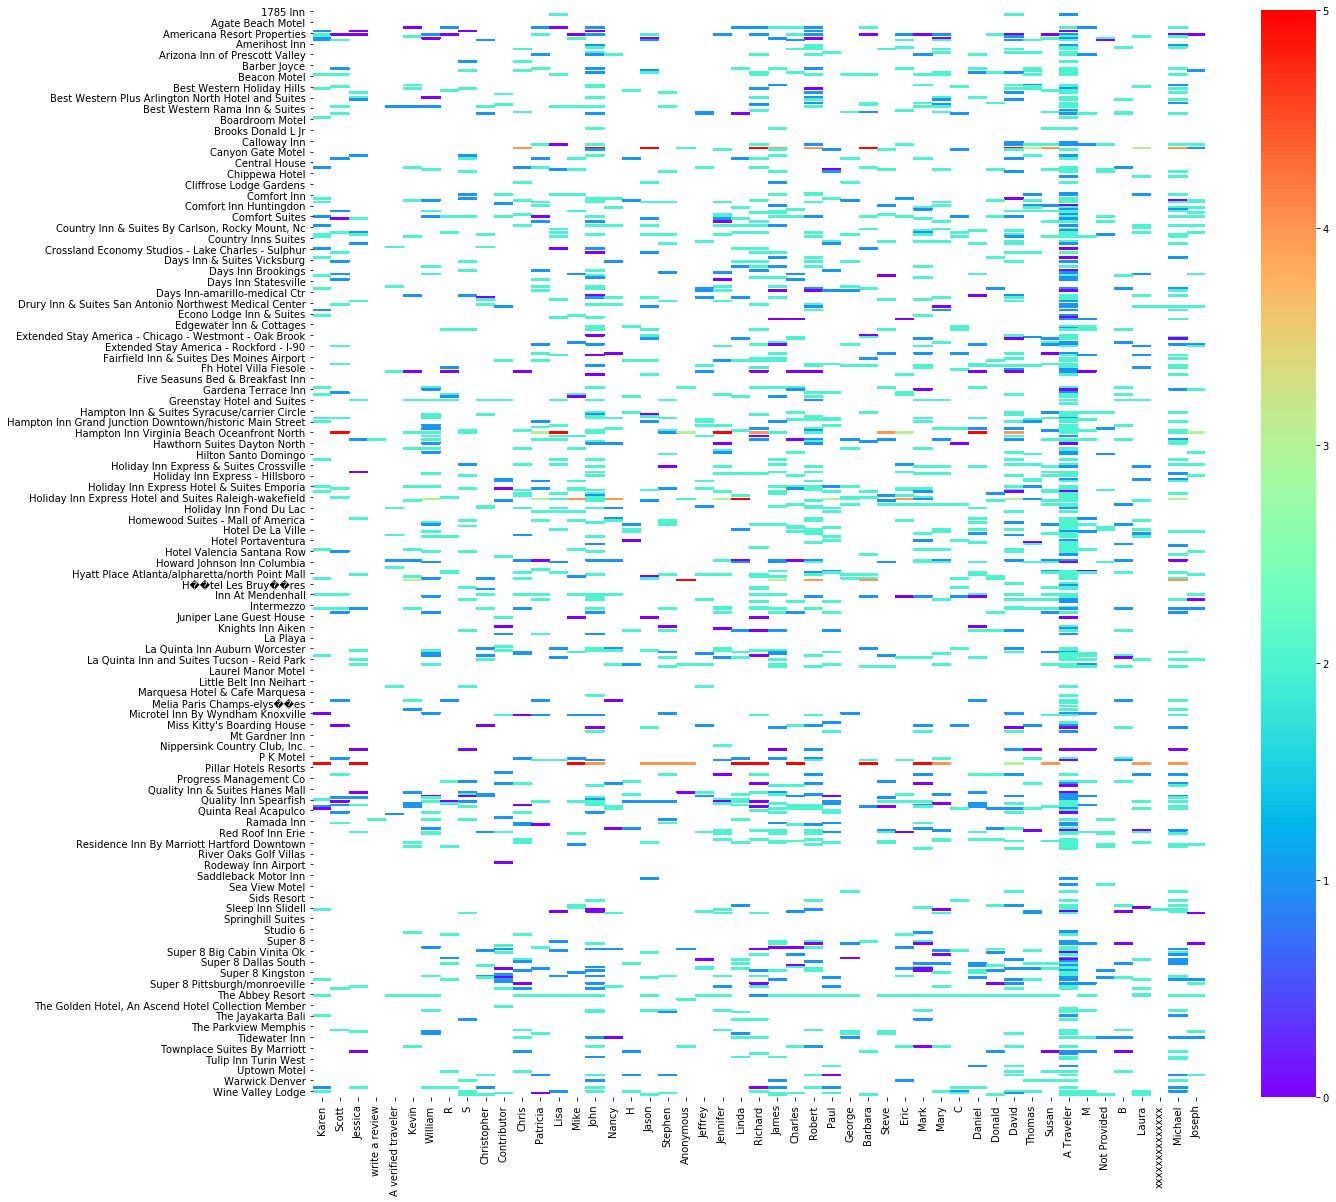

In [100]:
fig, ax = plt.subplots(figsize=(20,20))
seaborn.heatmap(df_hotels, cmap='rainbow', ax=ax)
plt.show()

To give the dataframe to pyanno we need to convert to np array and change the nans to intergers, lets use -1

In [101]:
hot_mat = np.array(df_hotels.fillna(-1).iloc[:, :].values)
anno_hot = AnnotationsContainer.from_array(hot_mat, missing_values=[-1])

In [102]:
anno_hot.annotations

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [103]:
anno_hot.labels

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

In [104]:
anno_hot.missing_values

[-1]

Look at coder agreement.

In [105]:
# 6 possible catagories
pyanno.measures.agreement.labels_frequency(anno_hot.annotations, 6)

array([0.07806534, 0.26262198, 0.63555367, 0.00636402, 0.0093339 ,
       0.00806109])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 4. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


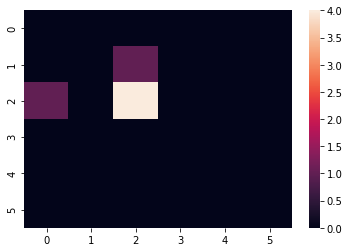

In [106]:
# 6 possible catagories
c = pyanno.measures.agreement.confusion_matrix(anno_hot.annotations[:,0], anno_hot.annotations[:,1], 6)
print(c)
ac = seaborn.heatmap(c)
plt.show()

Most agreement is on 2 i.e. an average hotel and there's little agreement as rating go higher, likely due to scarcity in the sample

In [107]:
scotts_pi(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.3787878787878787

In [108]:
krippendorffs_alpha(anno_hot.annotations[::])

0.398760907615921

In [109]:
cohens_kappa(anno_hot.annotations[:,0], anno_hot.annotations[:,1])

0.40328336902212697

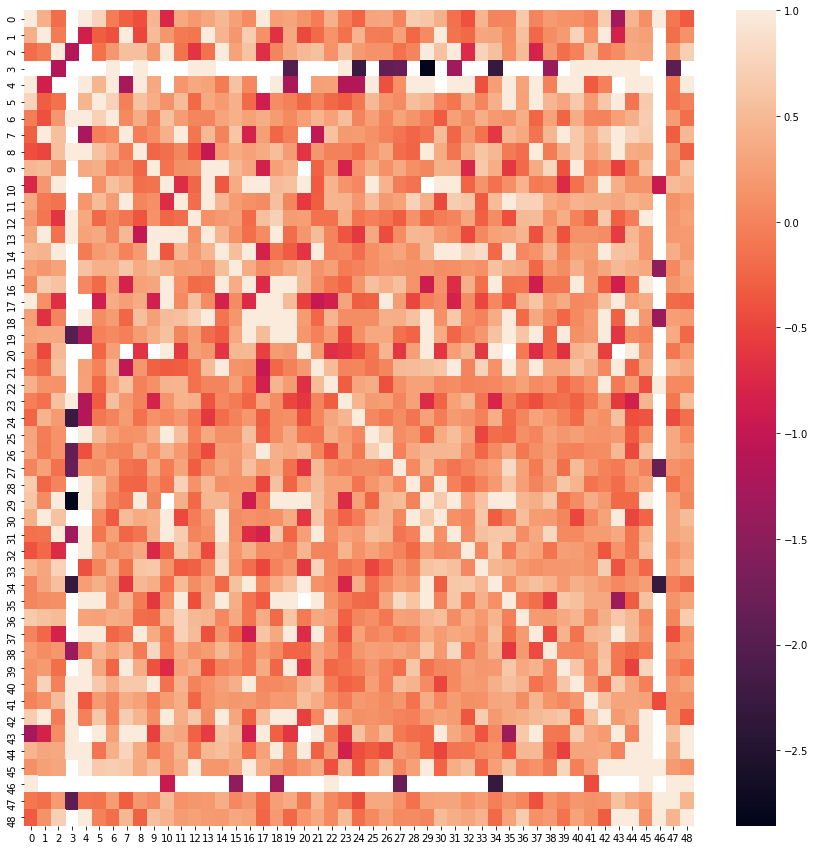

In [110]:
m = pairwise_matrix(cohens_kappa, anno_hot.annotations)
fig, ax = plt.subplots(figsize = (15, 15))
seaborn.heatmap(m, ax =ax)
plt.show();

In [111]:
model_hot = ModelBt.create_initial_state(6, 49)
model_hot.mle(anno_hot.annotations)
print(model.theta)
print(model_hot.log_likelihood(anno_hot.annotations))

[0.79038762 0.7396332  0.76128761 0.724171   0.71519901 0.71752942
 0.77231516 0.71556489]
-2709.6412444161965


In [112]:
def makeQuestionComparison(model, anno_target, num_questions=20):
    votes = []
    for r in anno_target.annotations:
        v = [0] * len(anno_target.labels)
        votes.append(v)
        for a in r:
            if a > -1:
                v[a] += 1
    votes_array = np.array(votes)
    posterior = model.infer_labels(anno_target.annotations)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10), sharey=True)

    seaborn.heatmap(votes_array[:num_questions], annot=True, ax=ax2)
    seaborn.heatmap(np.nan_to_num(posterior,0)[:num_questions], annot=True, ax =ax1)
    ax1.set_title("Model")
    ax2.set_title("Votes")
    return fig, (ax1, ax2)

(<Figure size 1080x720 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a4a877190>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a4bdba3d0>))

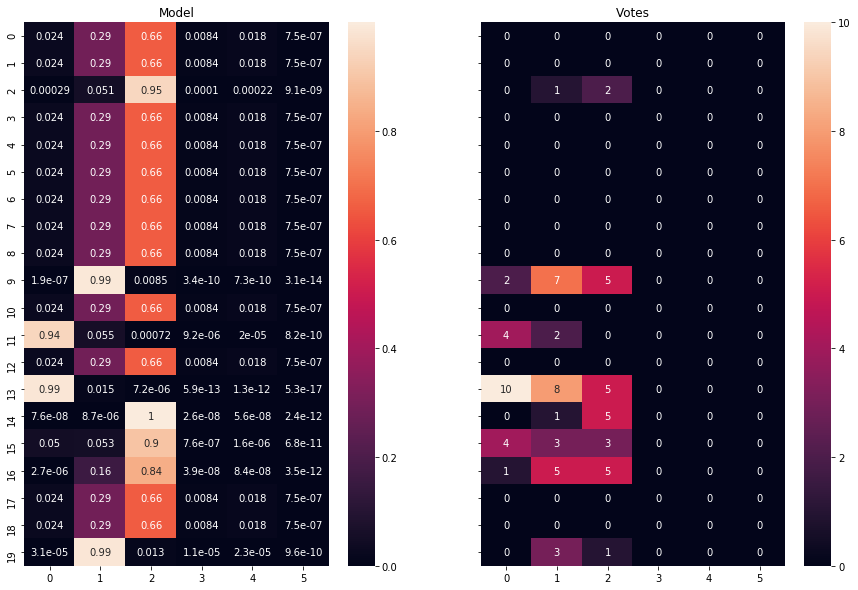

In [113]:
makeQuestionComparison(model_hot, anno_hot)

## <span style="color:red">*Your turn*</span>

<span style="color:red">In the cells immediately following, use the results of your content annotation survey to predict high and low-quality analysts, then predict MAP estimates for your codes in question. What do these estimates suggest about the distribution of skill among your coders? How different are these estimates from a majority vote?

mean [0.72378269 0.84114868 0.46758305 0.77560405 0.61109643 0.37976114
 0.58740191 0.7235163 ]
CI [0.13654403 0.12156863 0.12362574 0.10604412 0.12032445 0.13373843
 0.16786358 0.09969913]


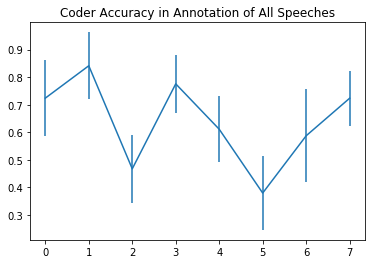

In [114]:
# Visualize coder accuracy
# All speeches
model = ModelBt.create_initial_state(5, 8) # 5 labels and 8 coders
model.mle(response_anno.annotations)
samples = model.sample_posterior_over_accuracy(response_anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y = samples.mean(axis=0)
y_ci = samples.std(axis=0)
print("mean", y)
print("CI", y_ci)

plt.figure()
plt.errorbar(range(8), y, yerr=y_ci)
plt.title("Coder Accuracy in Annotation of All Speeches")
plt.show()

mean [0.71472341 0.88787606 0.55468503 0.63255463 0.43747466 0.53314895
 0.47810903 0.79721834]
CI [0.13955885 0.06060007 0.15989798 0.13451093 0.1499925  0.15927655
 0.14945835 0.11644781]


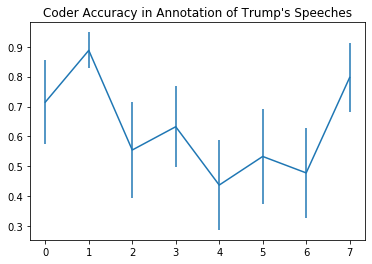

In [115]:
# Trump's speeches
model = ModelBt.create_initial_state(5, 8) # 5 labels and 8 coders
model.mle(trump_anno.annotations)
samples = model.sample_posterior_over_accuracy(trump_anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y = samples.mean(axis=0)
y_ci = samples.std(axis=0)
print("mean", y)
print("CI", y_ci)

plt.figure()
plt.errorbar(range(8), y, yerr=y_ci)
plt.title("Coder Accuracy in Annotation of Trump's Speeches")
plt.show()

mean [0.7495975  0.75427439 0.34560675 0.86713974 0.7572342  0.38970057
 0.72998367 0.68700402]
CI [0.13877781 0.12702201 0.18323887 0.11777985 0.15479322 0.15361862
 0.13436544 0.13111202]


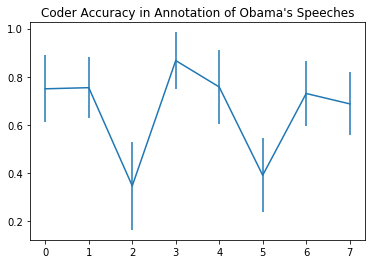

In [116]:
# Obama's speeches
model = ModelBt.create_initial_state(5, 8) # 5 labels and 8 coders
model.mle(obama_anno.annotations)
samples = model.sample_posterior_over_accuracy(obama_anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y = samples.mean(axis=0)
y_ci = samples.std(axis=0)
print("mean", y)
print("CI", y_ci)

plt.figure()
plt.errorbar(range(8), y, yerr=y_ci)
plt.title("Coder Accuracy in Annotation of Obama's Speeches")
plt.show()

As shown in the figures above, coders' accuracy varies according to the speech samples. 

In the annotation of the mixed speeches, coder1 is the most accurate, followed by coder 0, coder 7, coder 3 and coder 6. Yet coder5, coder4 and code2 have the lowest coding quality among all participants.

In the annotation of Trump's speeches, coder1 is still the most accurate analyst, followed by coder0 and coder7. Yet the ranking of low-quality coders has changed with coder6 being the most inaccurate coding. The accuracy level among coder2 to coder 6 is relatively smoother compared to that in the all-speeches sample.

In the annotation of Obama's speeches, the accuracy ranking sharply altered. Now the most accurate coder is coder3. Next to coder3, coder0, coder1, coder4, and coder6 have a relatively equal level of accuracy. Under this circumstance, coding provided by coder2 and coder5 can be regarded as the lowest quality.

In [117]:
# Predict MAP estimates
model = ModelBt.create_initial_state(5, 8)
model.map(response_anno.annotations)
print(model.theta)
print(model.log_likelihood(response_anno.annotations))
print(model.log_likelihood(trump_anno.annotations))
print(model.log_likelihood(obama_anno.annotations))

[0.80823951 0.91569516 0.45808081 0.80971935 0.62763066 0.3662363
 0.63130499 0.72746836]
-98.82518739480804
-52.542612607991224
-46.28257478681681


(<Figure size 1080x720 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a27bcf690>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a26a5af90>))

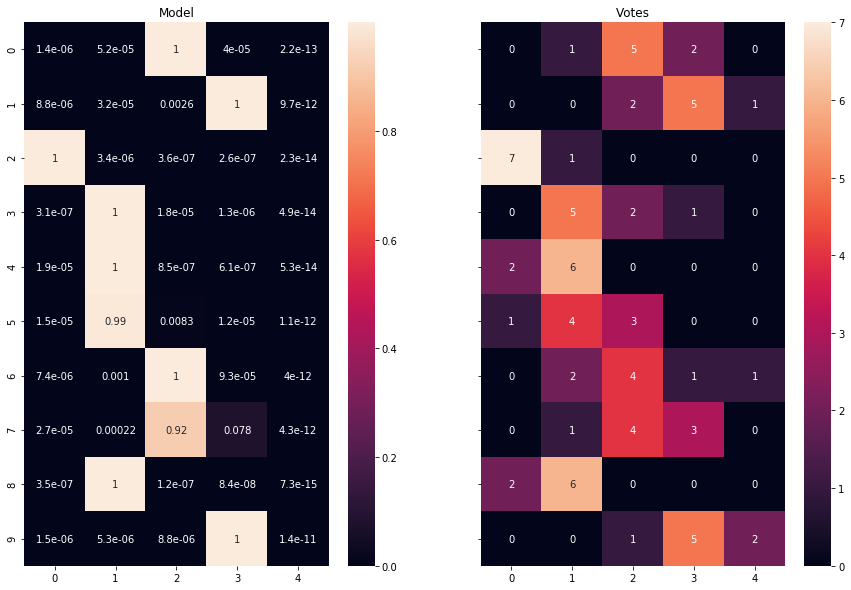

In [118]:
# All speeches
makeQuestionComparison(model, response_anno, num_questions=10)

(<Figure size 1080x720 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a269f97d0>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a4acbc250>))

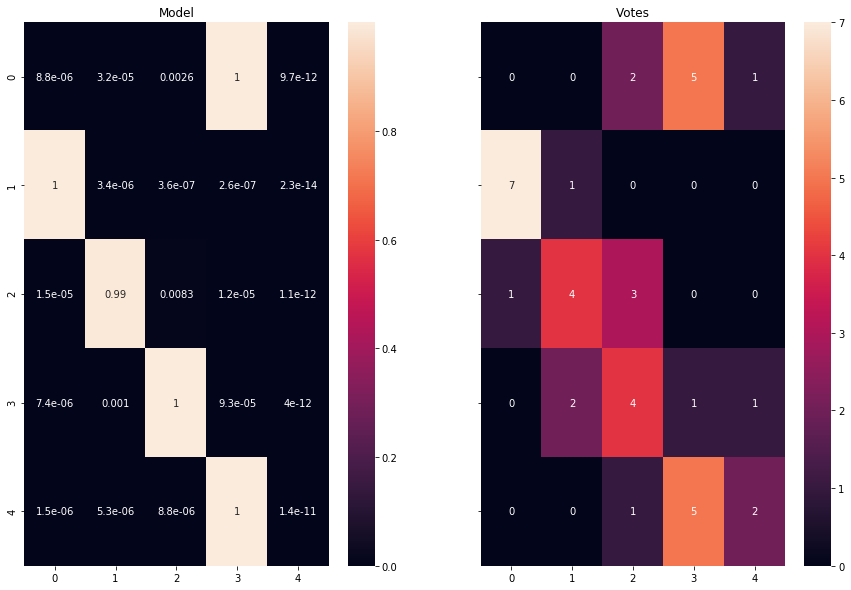

In [119]:
# Trump's speeches
makeQuestionComparison(model, trump_anno, num_questions=5)

(<Figure size 1080x720 with 4 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1a4af51410>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1a4b059390>))

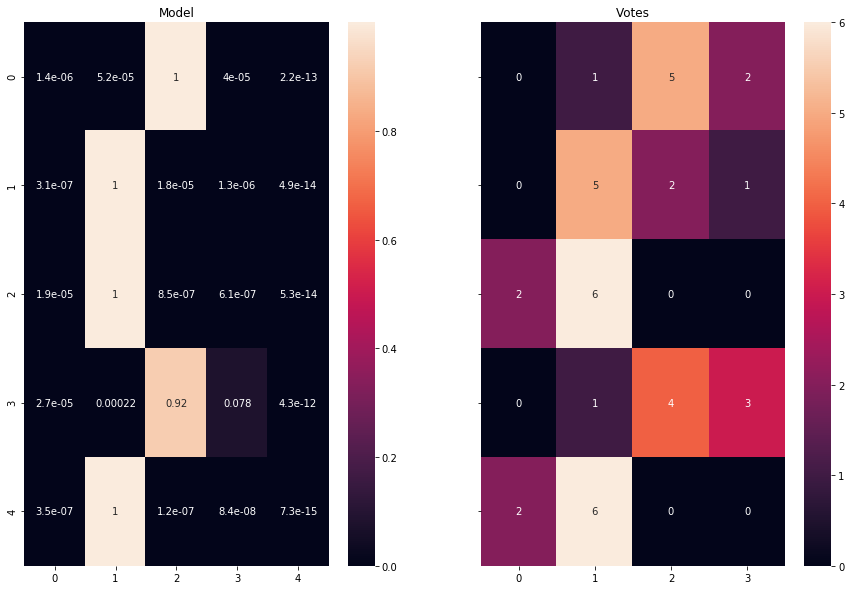

In [120]:
# Obama's speeches
makeQuestionComparison(model, obama_anno, num_questions=5)

The heatmaps above suggest that the maximum a posteriori estimation is very accurate. To be specific, the estimated results are the same as the results getting the most votes under the majority voting.